In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import scarches
from scarches.dataset import remove_sparsity
from lataq.models import EMBEDCVAE, TRANVAE

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')
    
%load_ext autoreload
%autoreload 2

# Create reference data without Delta cells and query data with Delta cells

In [2]:
adata = sc.read(
    f'../data/pancreas.h5ad'
)
adata

AnnData object with n_obs × n_vars = 16382 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score'
    obsm: 'X_seurat', 'X_symphony'

In [3]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [4]:
condition_key = "study"
cell_type_keys = ["cell_type"]
remove_cts = ["beta"]
reference = ["inDrop1", 
             "inDrop2", 
             "inDrop3", 
             "inDrop4", 
             "fluidigmc1", 
             "smartseq2", 
             "smarter"]
query = ["celseq", 
         "celseq2"]

In [5]:
cell_type_key = cell_type_keys[-1]
adata = remove_sparsity(adata)
ref_adata = adata[adata.obs.study.isin(reference)].copy()
ref_adata = ref_adata[~ref_adata.obs.cell_type.isin(remove_cts)].copy()
query_adata = adata[adata.obs.study.isin(query)].copy()
adata = ref_adata.concatenate(query_adata)

In [6]:
adata_plot = adata.copy()
sc.pp.normalize_total(adata_plot)
sc.pp.log1p(adata_plot)
sc.pp.pca(adata_plot)
sc.pp.neighbors(adata_plot)
sc.tl.umap(adata_plot)

<AxesSubplot:title={'center':'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

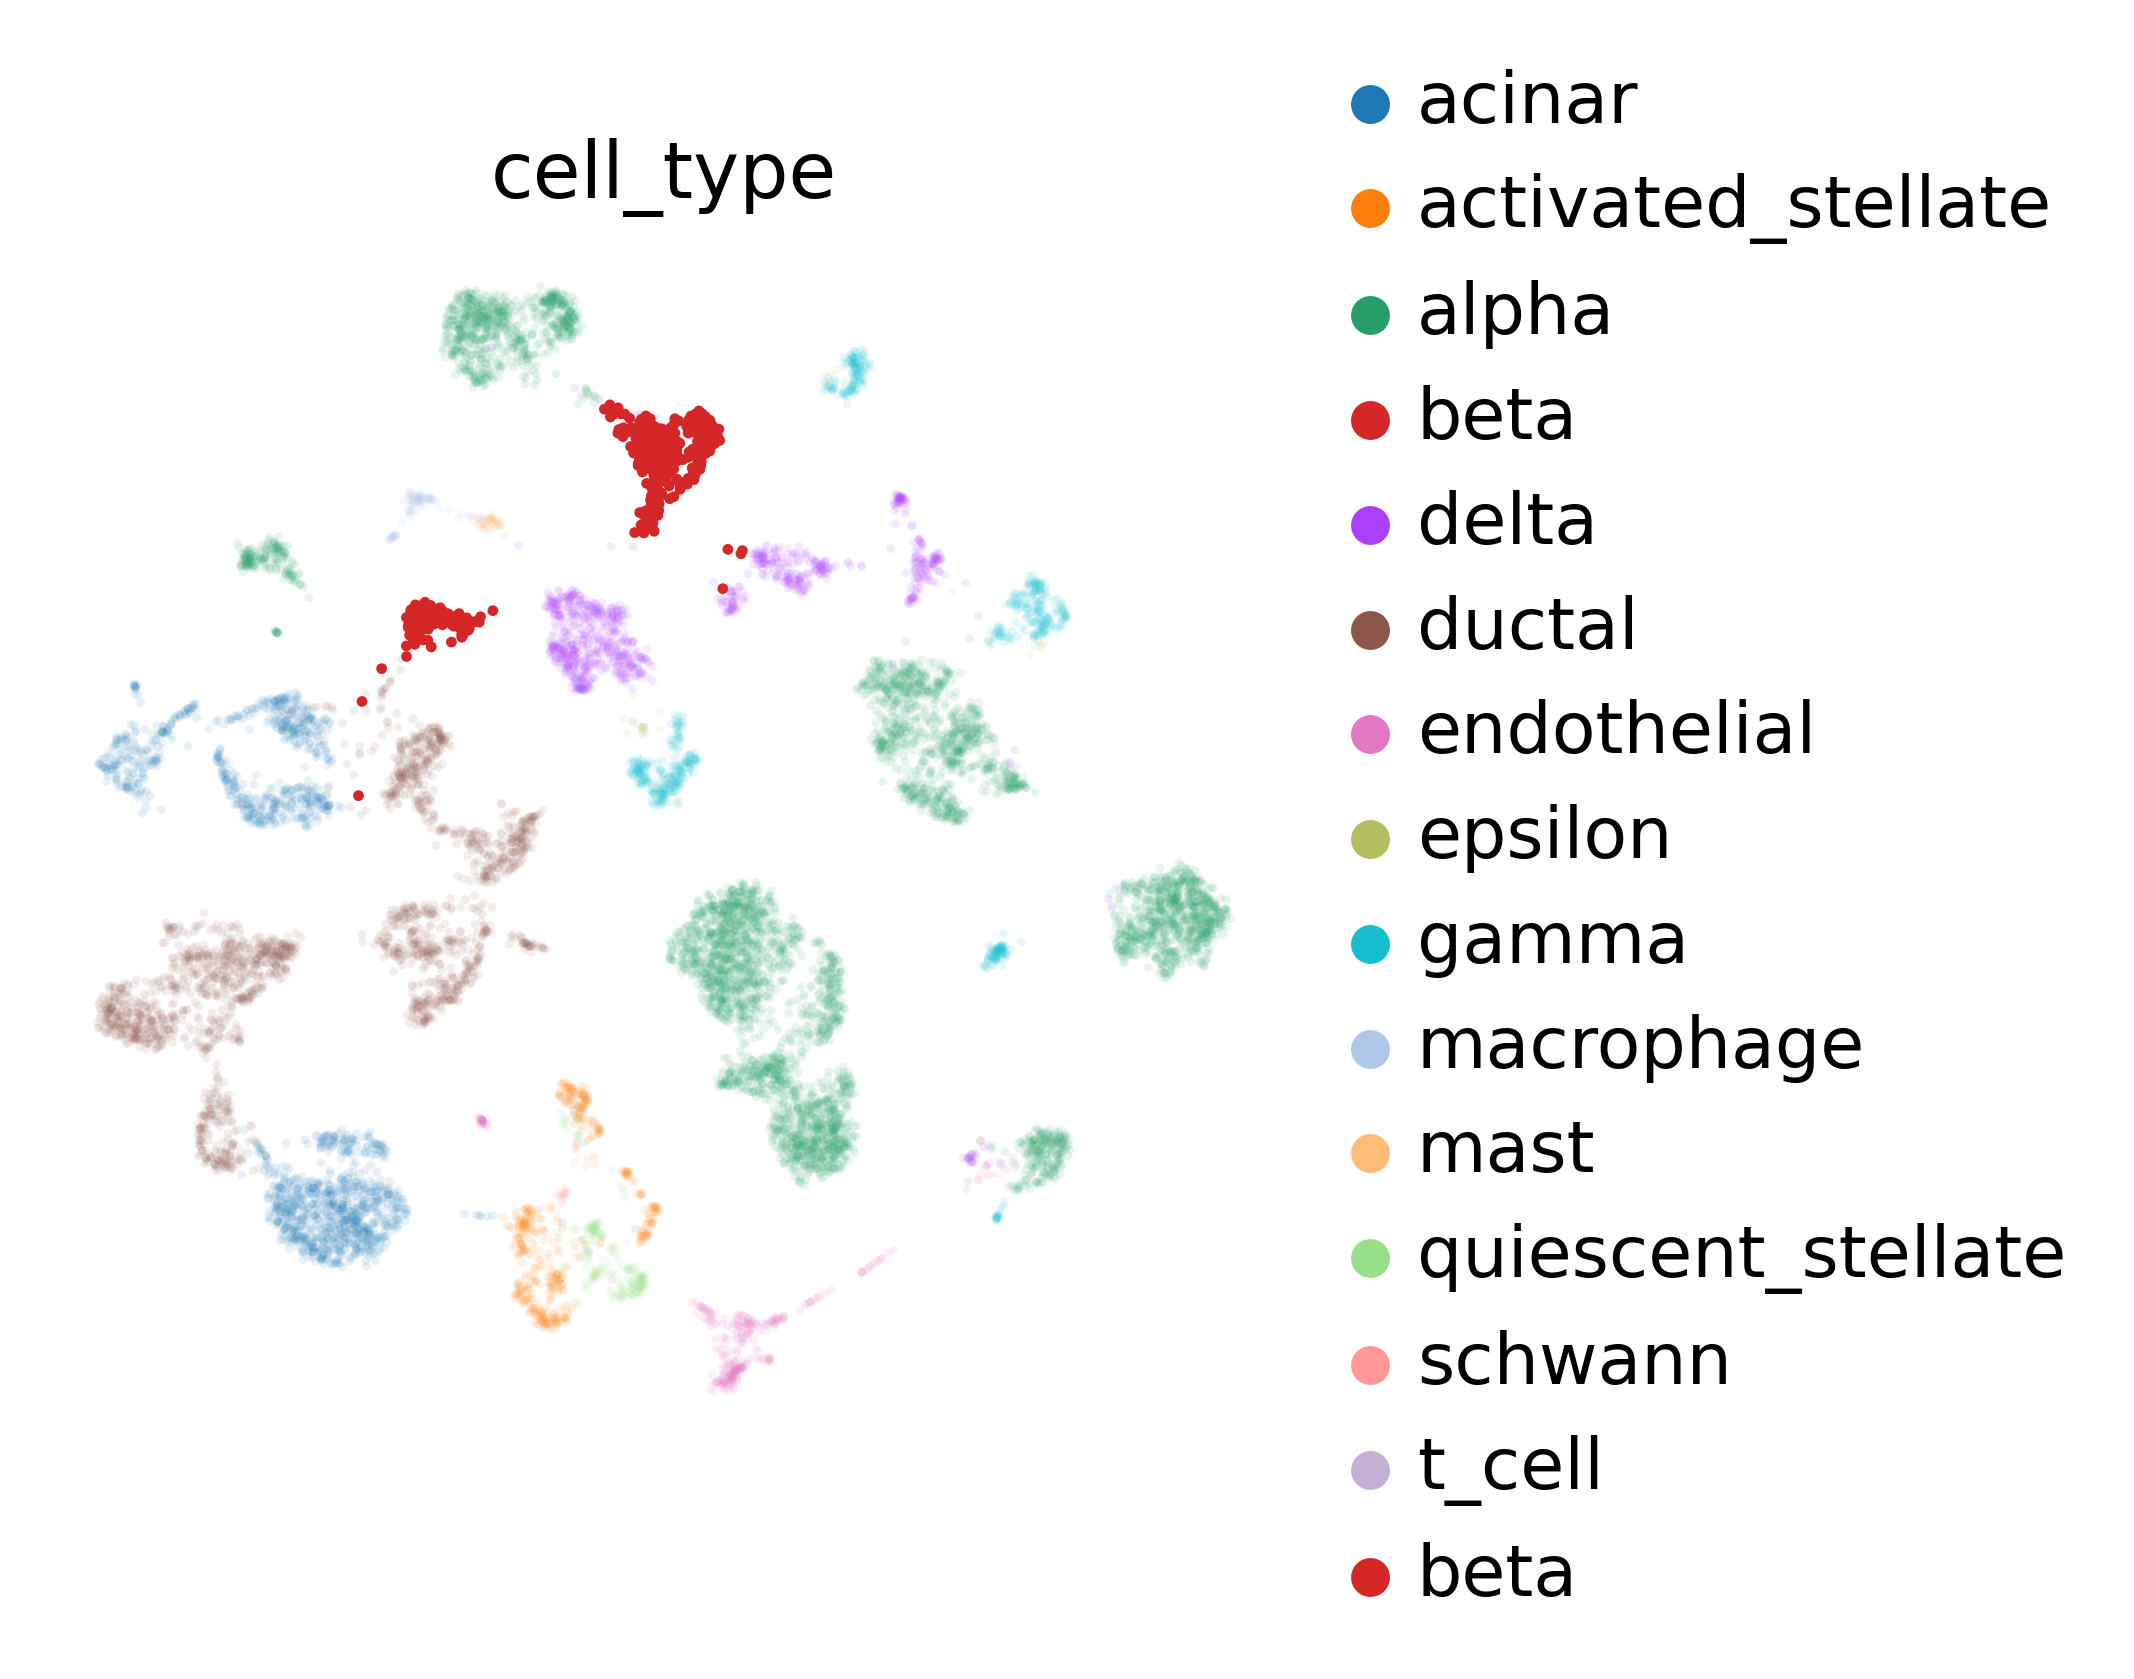

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.umap(adata_plot, color='cell_type', size=10, frameon=False, show=False, ax=ax, alpha=0.1)
sc.pl.umap(adata_plot[adata_plot.obs['cell_type']=='beta'], size=15, color='cell_type', frameon=False, show=False, ax=ax)

<AxesSubplot:title={'center':'study'}, xlabel='UMAP1', ylabel='UMAP2'>

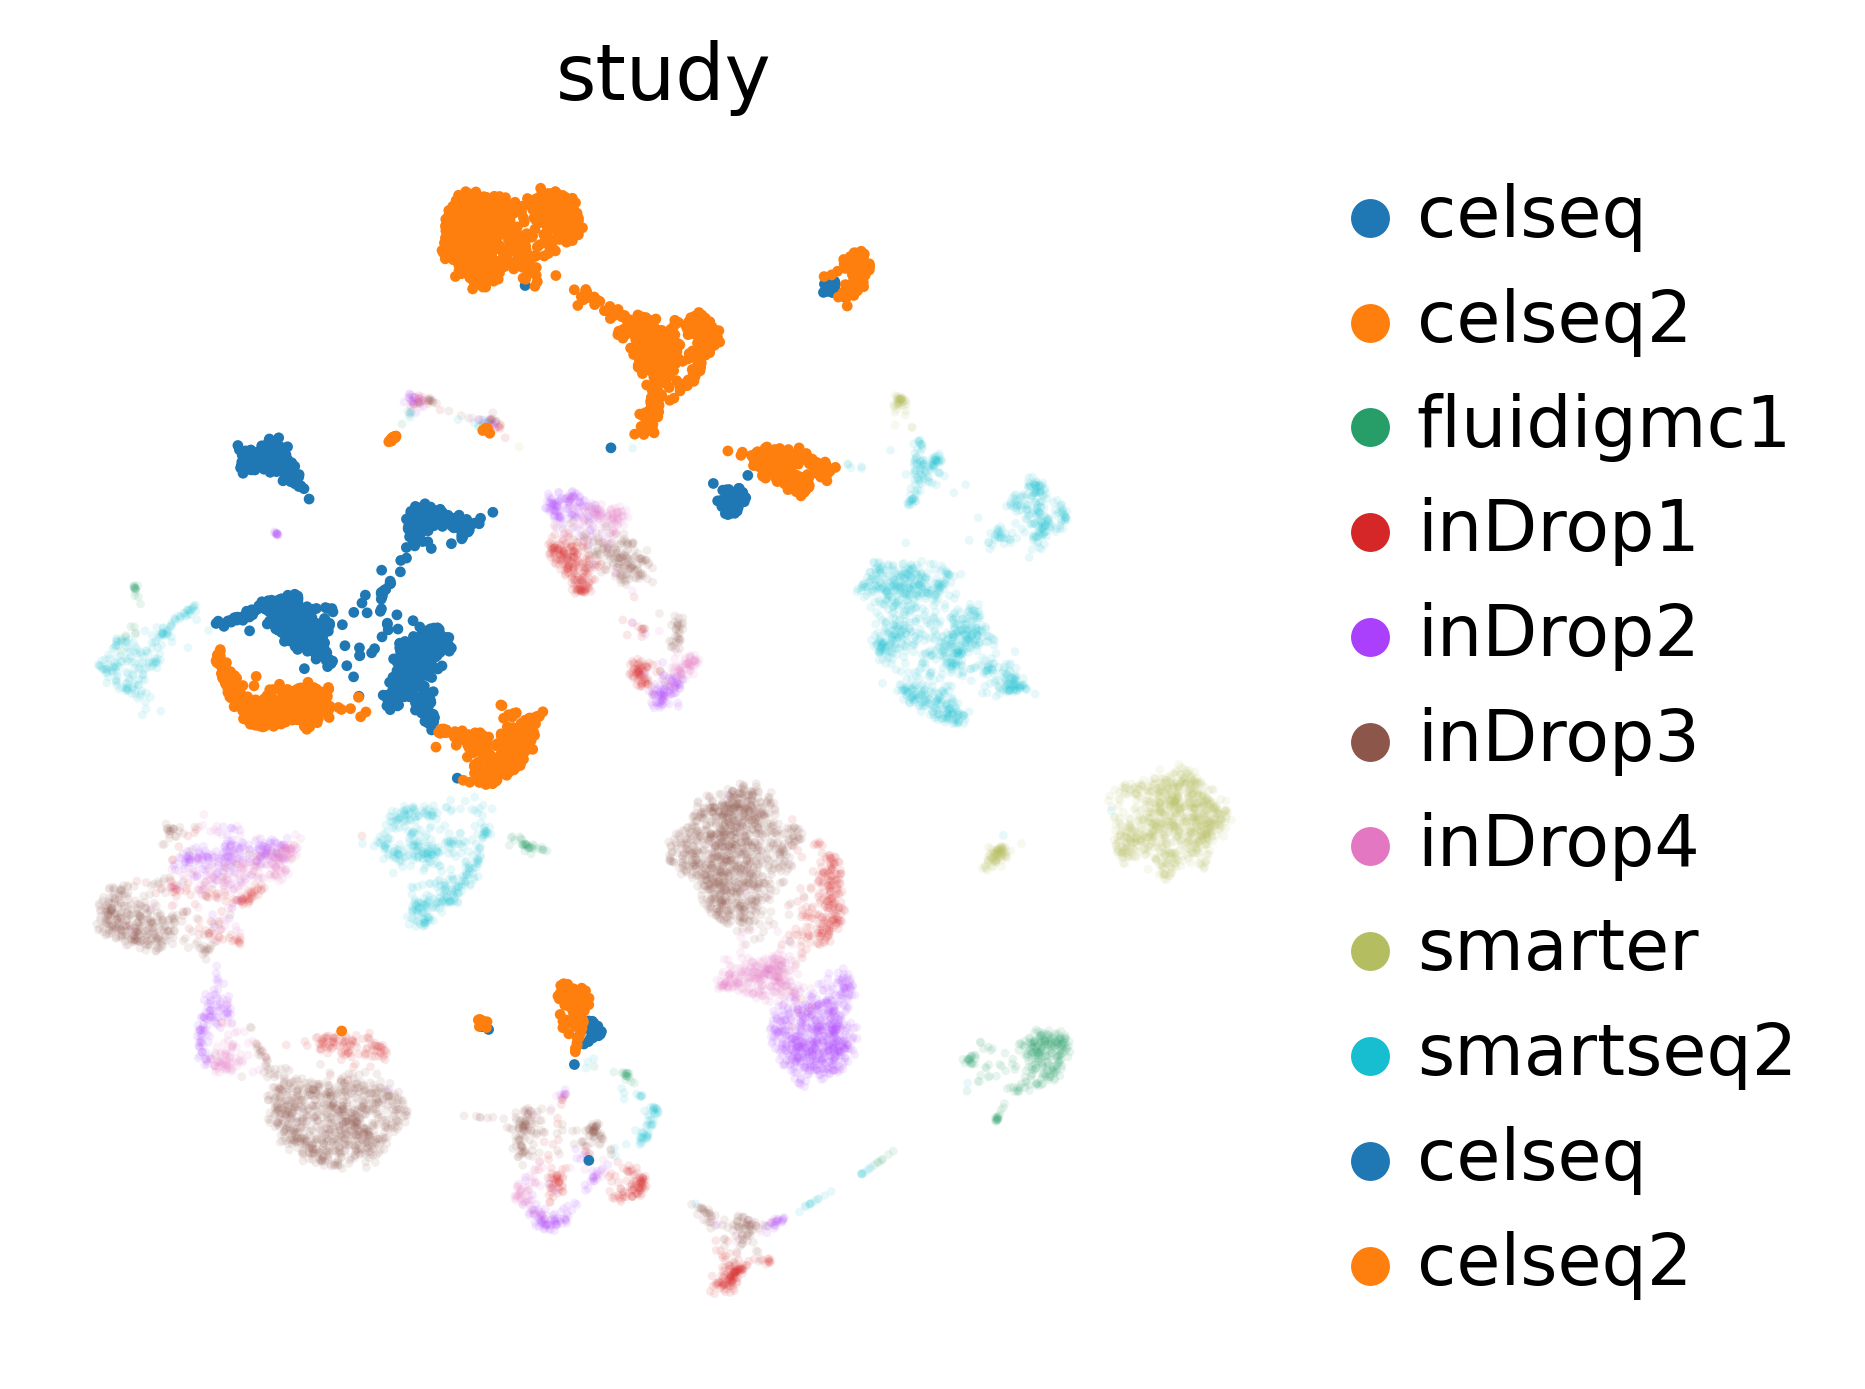

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.umap(adata_plot, color='study', size=10, frameon=False, show=False, ax=ax, alpha=0.1)
sc.pl.umap(adata_plot[adata_plot.obs['study'].isin(query)], size=15, color='study', frameon=False, show=False, ax=ax)

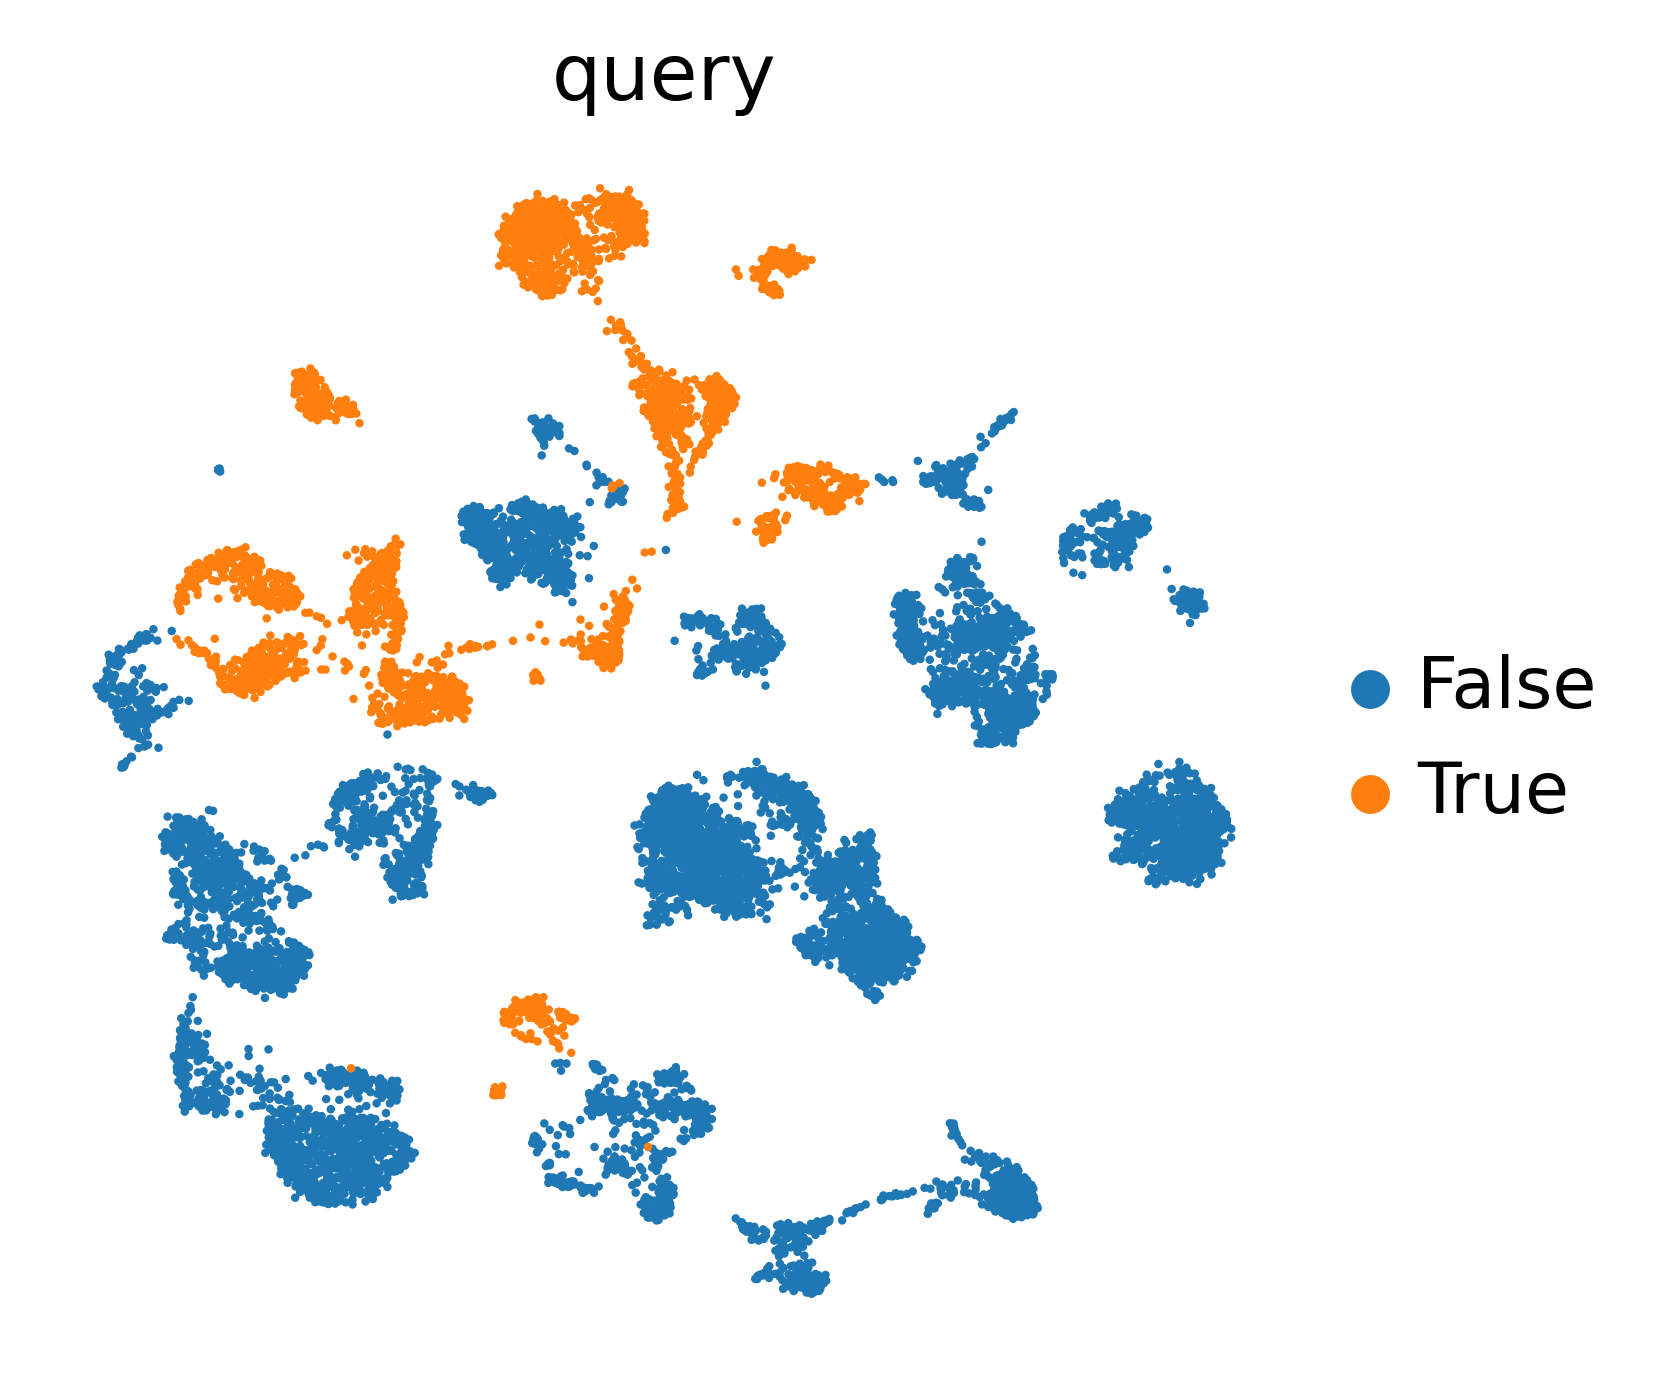

In [9]:
adata_plot.obs['query'] = adata_plot.obs['study'].isin(query).astype('category')
sc.pl.umap(adata_plot, color='query', frameon=False)

# Supervised Reference Training (100% labels used)

In [10]:
lataq_ref = EMBEDCVAE(
    adata=ref_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_keys,
    hidden_layer_sizes=[128, 128, 128],
)

Embedding dictionary:
 	Num conditions: 7
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [11]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_landmark_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

lataq_ref.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=400,
    alpha_epoch_anneal=1e6,
    eta=10,
    clustering_res=2,
)

 |████████████████████| 100.0%  - val_loss: 1023.8912353516 - val_trvae_loss: 1022.1079330444 - val_landmark_loss: 1.7832918465 - val_labeled_loss: 0.1783291856
Saving best state of network...
Best State was in Epoch 499


# Unsupervised Query Training (0 labels used)

In [12]:
lataq = EMBEDCVAE.load_query_data(
    adata=query_adata,
    reference_model=lataq_ref,
    labeled_indices=[]
)

Embedding dictionary:
 	Num conditions: 9
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [13]:
lataq.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=400,
    eta=10,
    clustering_res=2,
)

Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
 |████████████████----| 80.0%  - val_loss: 2335.6770019531 - val_trvae_loss: 2335.6770019531
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 25 clusters.
 |██████████████████--| 92.0%  - val_loss: 2334.6282552083 - val_trvae_loss: 2334.6222330729 - val_landmark_loss: 0.0060332244 - val_unlabeled_loss: 0.6033224066
ADJUSTED LR
 |██████████████████--| 93.4%  - val_loss: 2331.0546875000 - val_trvae_loss: 2331.0486653646 - val_landmark_loss: 0.0060154625 - val_unlabeled_loss: 0.6015462081
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 445


In [14]:
lataq.save(
    'embedcvae_pancreas_novel',
    overwrite=True
)

# Visualizing resulting adata latent representation and landmarks

In [270]:
lataq = EMBEDCVAE.load(
    dir_path='embedcvae_pancreas_novel',
    adata=query_adata,
)

AnnData object with n_obs × n_vars = 3289 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'trvae_size_factors', 'trvae_labeled'
    uns: 'neighbors', 'umap'
    obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'
Embedding dictionary:
 	Num conditions: 9
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [271]:
def detect_threshold(probs, labels):
    candidates = np.linspace(np.min(probs), np.max(probs), 1000)
    accs = []
    for thr in candidates:
        outcome = (probs > thr)
        acc = np.sum((outcome == labels)) / len(outcome)
        accs.append(acc)
    return accs, candidates

In [272]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def conf_matrix_plot(y_true, y_pred, labels):
    conf_matrix = confusion_matrix(
        y_true=y_true,
        y_pred=y_pred,
        labels=labels,
    )
    conf_matrix_norm = confusion_matrix(
        y_true=y_true,
        y_pred=y_pred,
        labels=labels,
        normalize='true'
    )

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    sns.heatmap(
        conf_matrix_norm,
        annot=conf_matrix,
        ax=ax,
        fmt='d',
        xticklabels=labels,
        yticklabels=labels,
    )

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                    precision    recall  f1-score   support

             gamma       0.99      0.98      0.99       128
            acinar       0.95      1.00      0.97       502
             alpha       0.98      0.97      0.98      1034
             delta       0.30      1.00      0.46       253
              beta       0.00      0.00      0.00       606
            ductal       0.99      0.96      0.97       585
       endothelial       1.00      1.00      1.00        26
activated_stellate       0.89      0.99      0.94       109
           schwann       1.00      1.00      1.00         5
              mast       1.00      0.71      0.83         7
        macrophage       1.00      0.94      0.97        16
           epsilon       0.57      0.80      0.67         5
quiescent_stellate       0.86      0.46      0.60        13

          accuracy                           0.80      3289
         macro avg       0.81      0.83      0.80      3289
      weighted avg       0.74      0.8

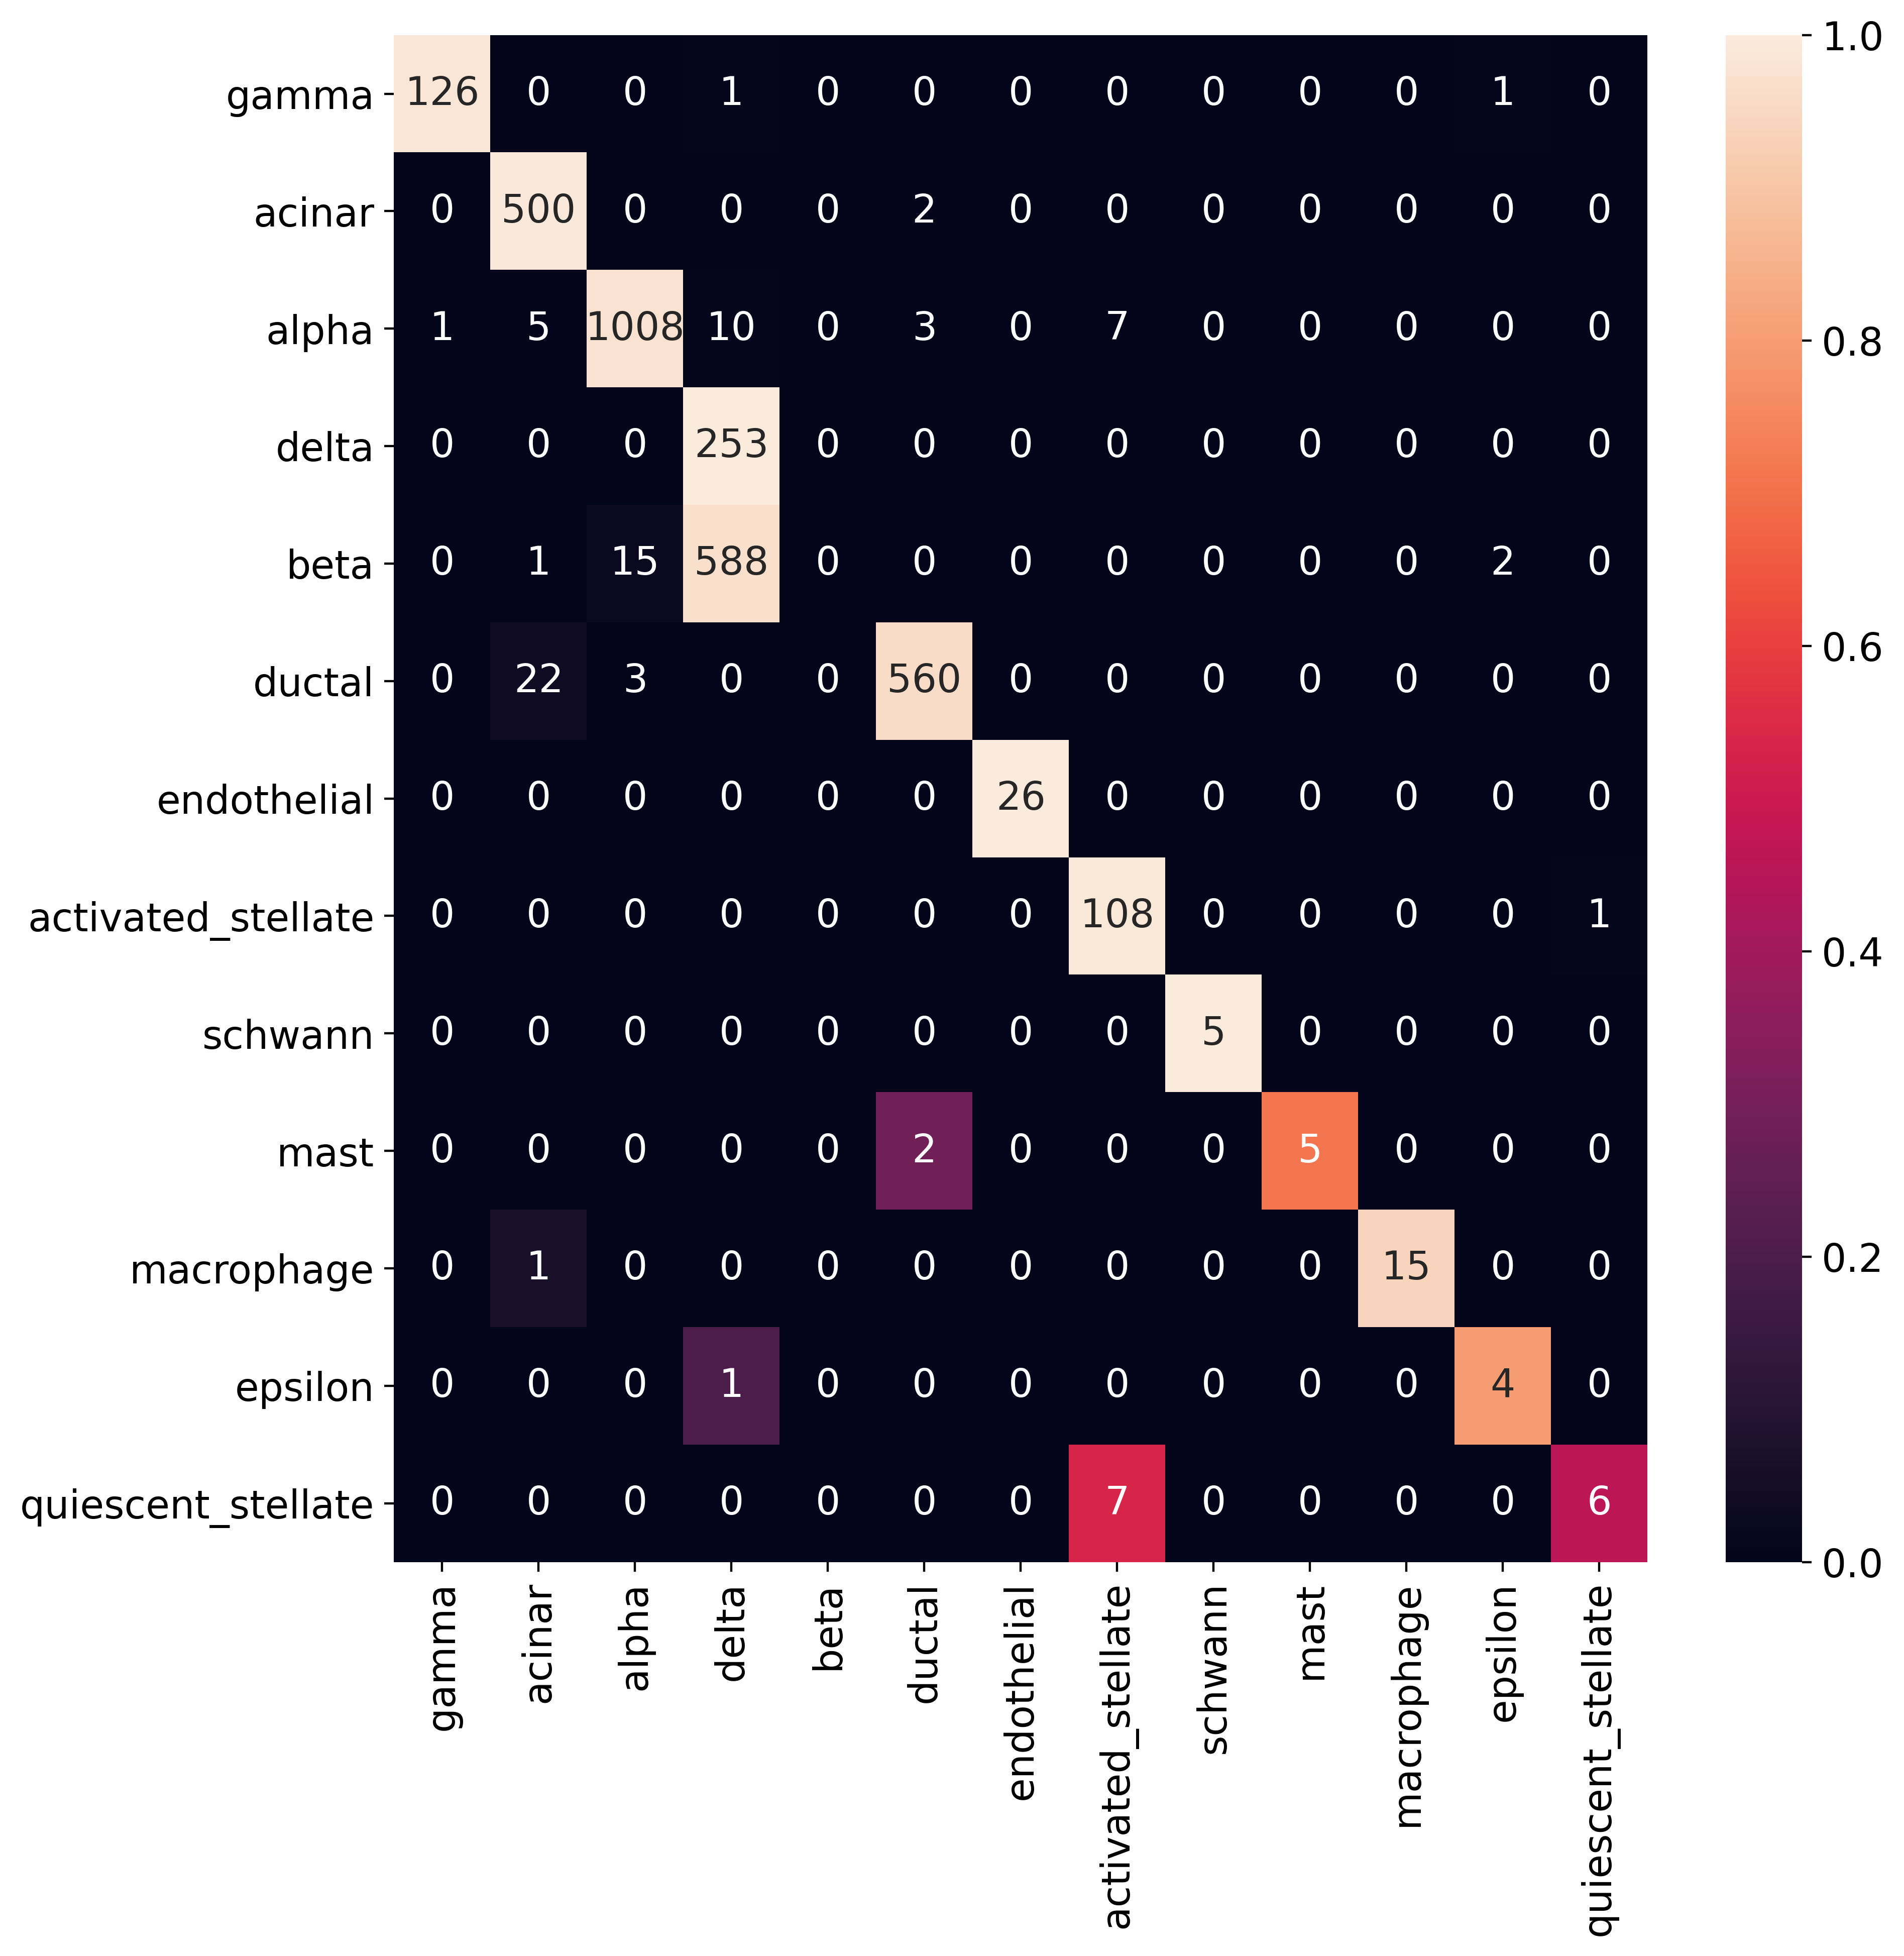

In [273]:
results_dict_q = lataq.classify(
    metric="dist",
    get_prob=False,
    threshold=-1e10
)

preds_q = results_dict_q[cell_type_key]['preds']
probs_q = results_dict_q[cell_type_key]['probs']
print(classification_report(
    y_true=query_adata.obs[cell_type_key],
    y_pred=preds_q,
    labels=np.array(query_adata.obs[cell_type_key].unique().tolist())
))
conf_matrix_plot(
    y_true=query_adata.obs[cell_type_key],
    y_pred=preds_q,
    labels=np.array(query_adata.obs[cell_type_key].unique().tolist())
)

data_latent = lataq.get_latent(mean=True)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs[condition_key] = query_adata.obs[condition_key].tolist()
adata_latent.obs[cell_type_key] = query_adata.obs[cell_type_key].tolist()
adata_latent.obs[f'{cell_type_key}_pred'] = preds_q.tolist()
adata_latent.obs[f'{cell_type_key}_prob'] = probs_q.tolist()
adata_latent.obs[f'classifier_outcome'] = (
    adata_latent.obs[f'{cell_type_key}_pred'] == adata_latent.obs[f'{cell_type_key}']
)

#Scale distances between 0 and 1
probs_scaled = (probs_q - probs_q.min(axis=0)) / (probs_q.max(axis=0) - probs_q.min(axis=0))
adata_latent.obs[f'{cell_type_key}_prob_scaled'] = probs_scaled

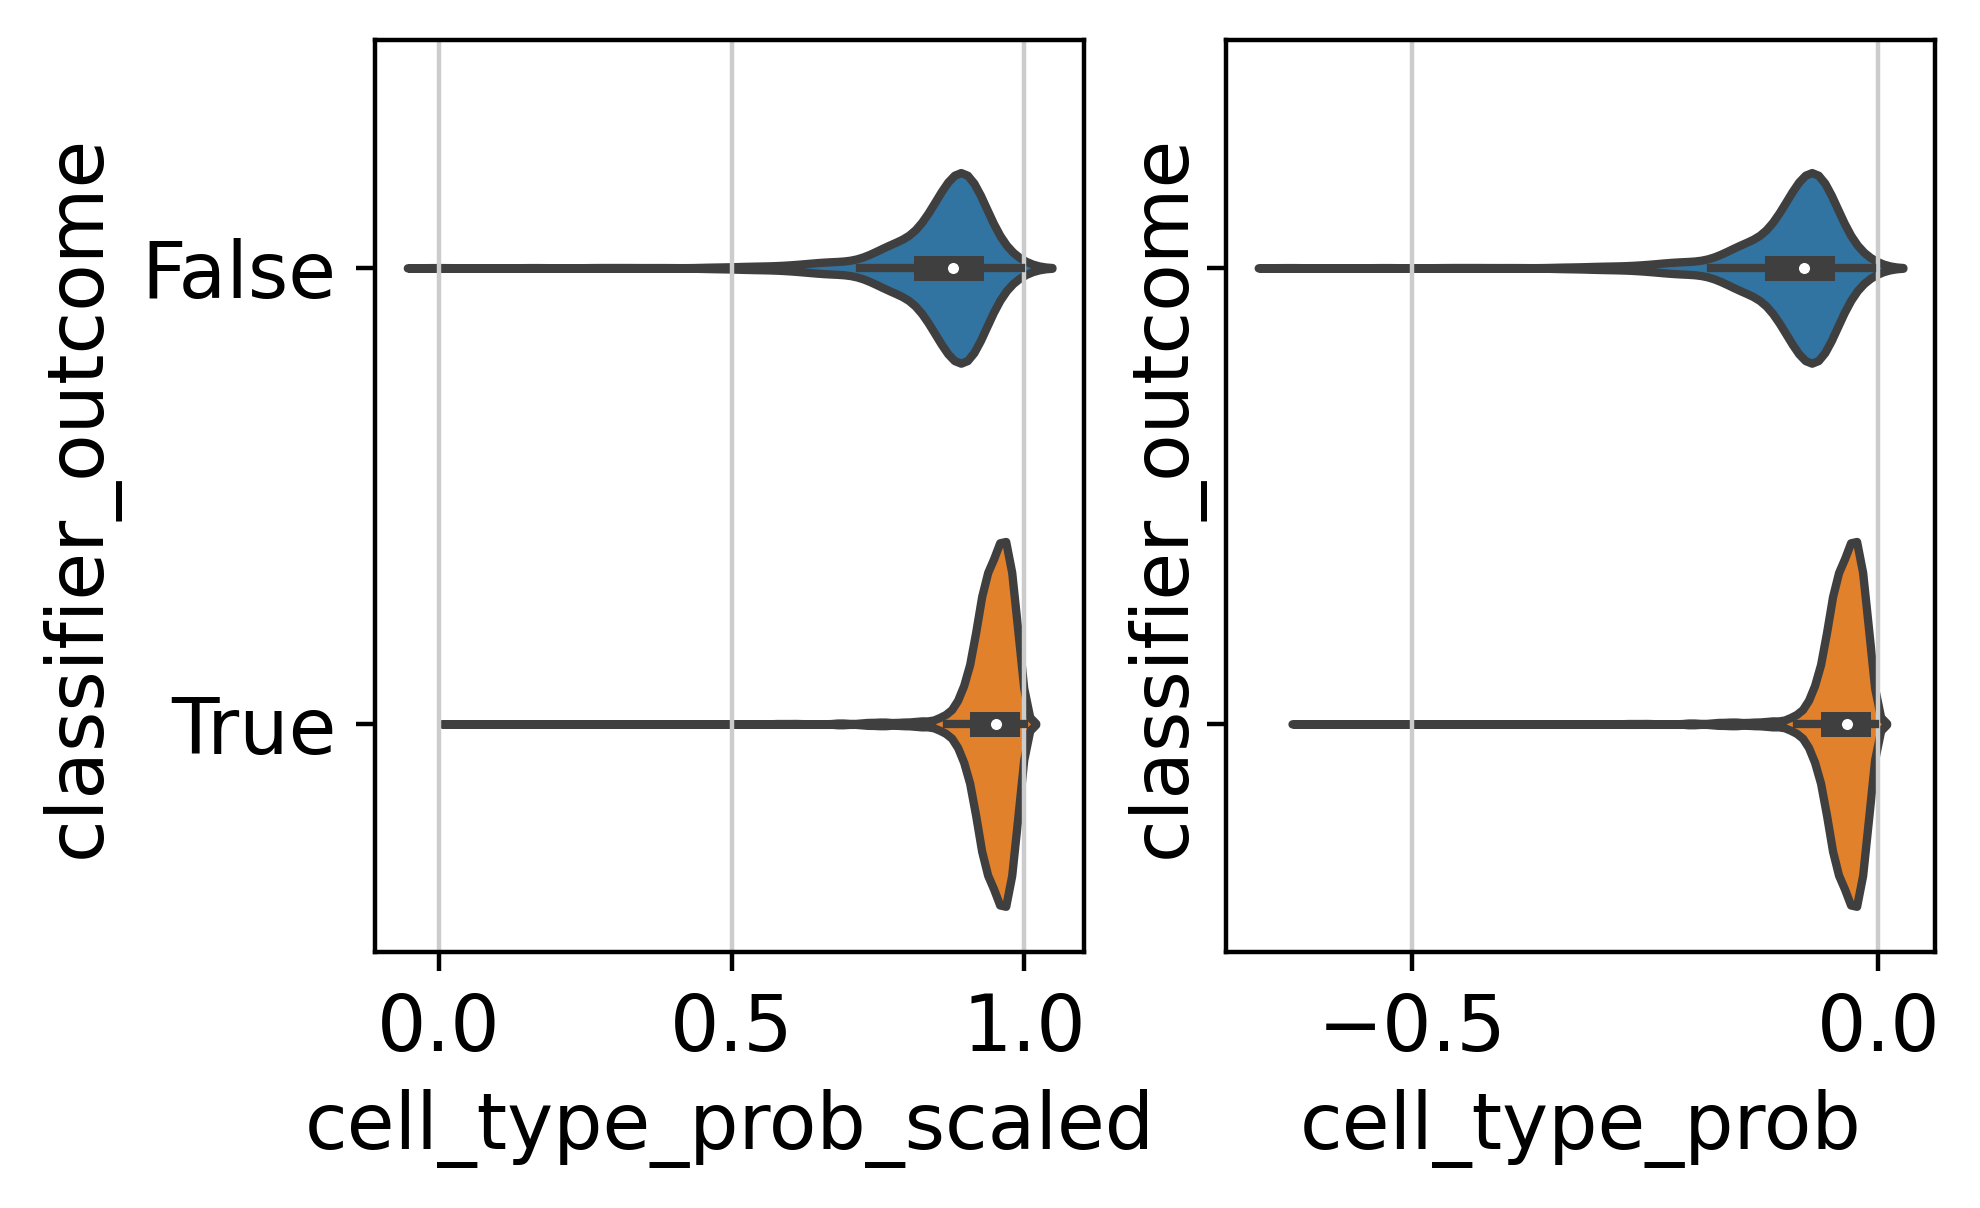

<Figure size 800x800 with 0 Axes>

In [274]:
fig, ax = plt.subplots(1, 2, figsize=(5, 3), sharey=True)
sns.violinplot(
    x=adata_latent.obs['cell_type_prob_scaled'], 
    y=adata_latent.obs['classifier_outcome'].astype('category'),
    ax=ax[0]
)
plt.figure()
sns.violinplot(
    x=adata_latent.obs['cell_type_prob'], 
    y=adata_latent.obs['classifier_outcome'].astype('category'),
    ax=ax[1]
)
plt.tight_layout()

(0.0, 1.0)

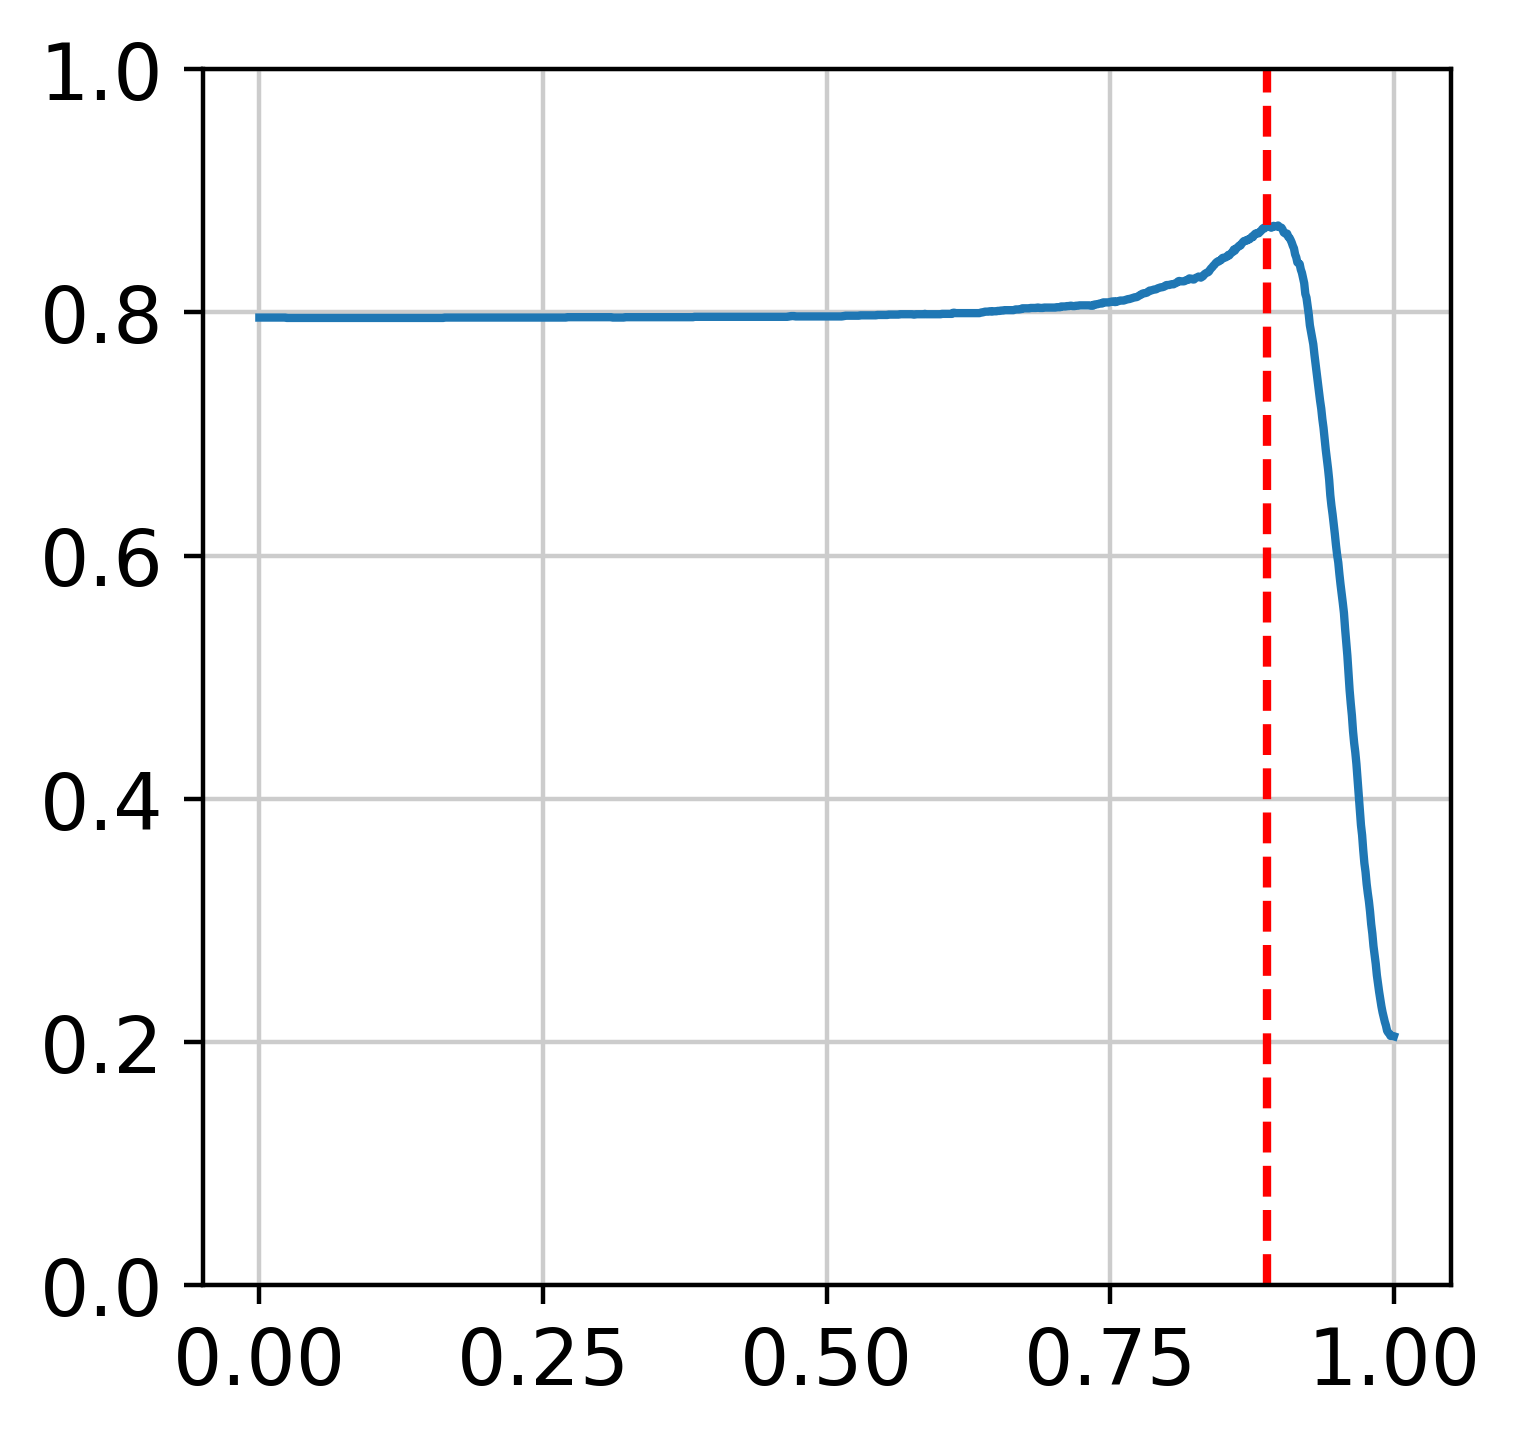

In [275]:
accs, candidates = detect_threshold(adata_latent.obs['cell_type_prob_scaled'], adata_latent.obs['classifier_outcome'])
plt.plot(candidates, accs)
plt.axvline(candidates[np.argmax(accs)], color='r', linestyle='--')
plt.ylim([0, 1])

In [276]:
results_dict_q = lataq.classify(
    metric="dist",
    get_prob=True,
    threshold=-1e10
)

preds_q = results_dict_q[cell_type_key]['preds']
probs_q = results_dict_q[cell_type_key]['probs']
print(classification_report(
    y_true=query_adata.obs[cell_type_key],
    y_pred=preds_q,
    labels=np.array(query_adata.obs[cell_type_key].unique().tolist())
))

data_latent = lataq.get_latent(mean=True)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs[condition_key] = query_adata.obs[condition_key].tolist()
adata_latent.obs[cell_type_key] = query_adata.obs[cell_type_key].tolist()
adata_latent.obs[f'{cell_type_key}_pred'] = preds_q.tolist()
adata_latent.obs[f'{cell_type_key}_prob'] = probs_q.tolist()
adata_latent.obs[f'classifier_outcome'] = (
    adata_latent.obs[f'{cell_type_key}_pred'] == adata_latent.obs[f'{cell_type_key}']
)

#Scale distances between 0 and 1
probs_scaled = (probs_q - probs_q.min(axis=0)) / (probs_q.max(axis=0) - probs_q.min(axis=0))
adata_latent.obs[f'{cell_type_key}_prob_scaled'] = probs_scaled

                    precision    recall  f1-score   support

             gamma       0.99      0.98      0.99       128
            acinar       0.95      1.00      0.97       502
             alpha       0.99      0.98      0.98      1034
             delta       0.30      1.00      0.46       253
              beta       0.00      0.00      0.00       606
            ductal       0.99      0.96      0.97       585
       endothelial       1.00      1.00      1.00        26
activated_stellate       0.89      0.99      0.94       109
           schwann       1.00      1.00      1.00         5
              mast       1.00      0.71      0.83         7
        macrophage       1.00      0.94      0.97        16
           epsilon       0.57      0.80      0.67         5
quiescent_stellate       0.88      0.54      0.67        13

          accuracy                           0.80      3289
         macro avg       0.81      0.84      0.80      3289
      weighted avg       0.74      0.8

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

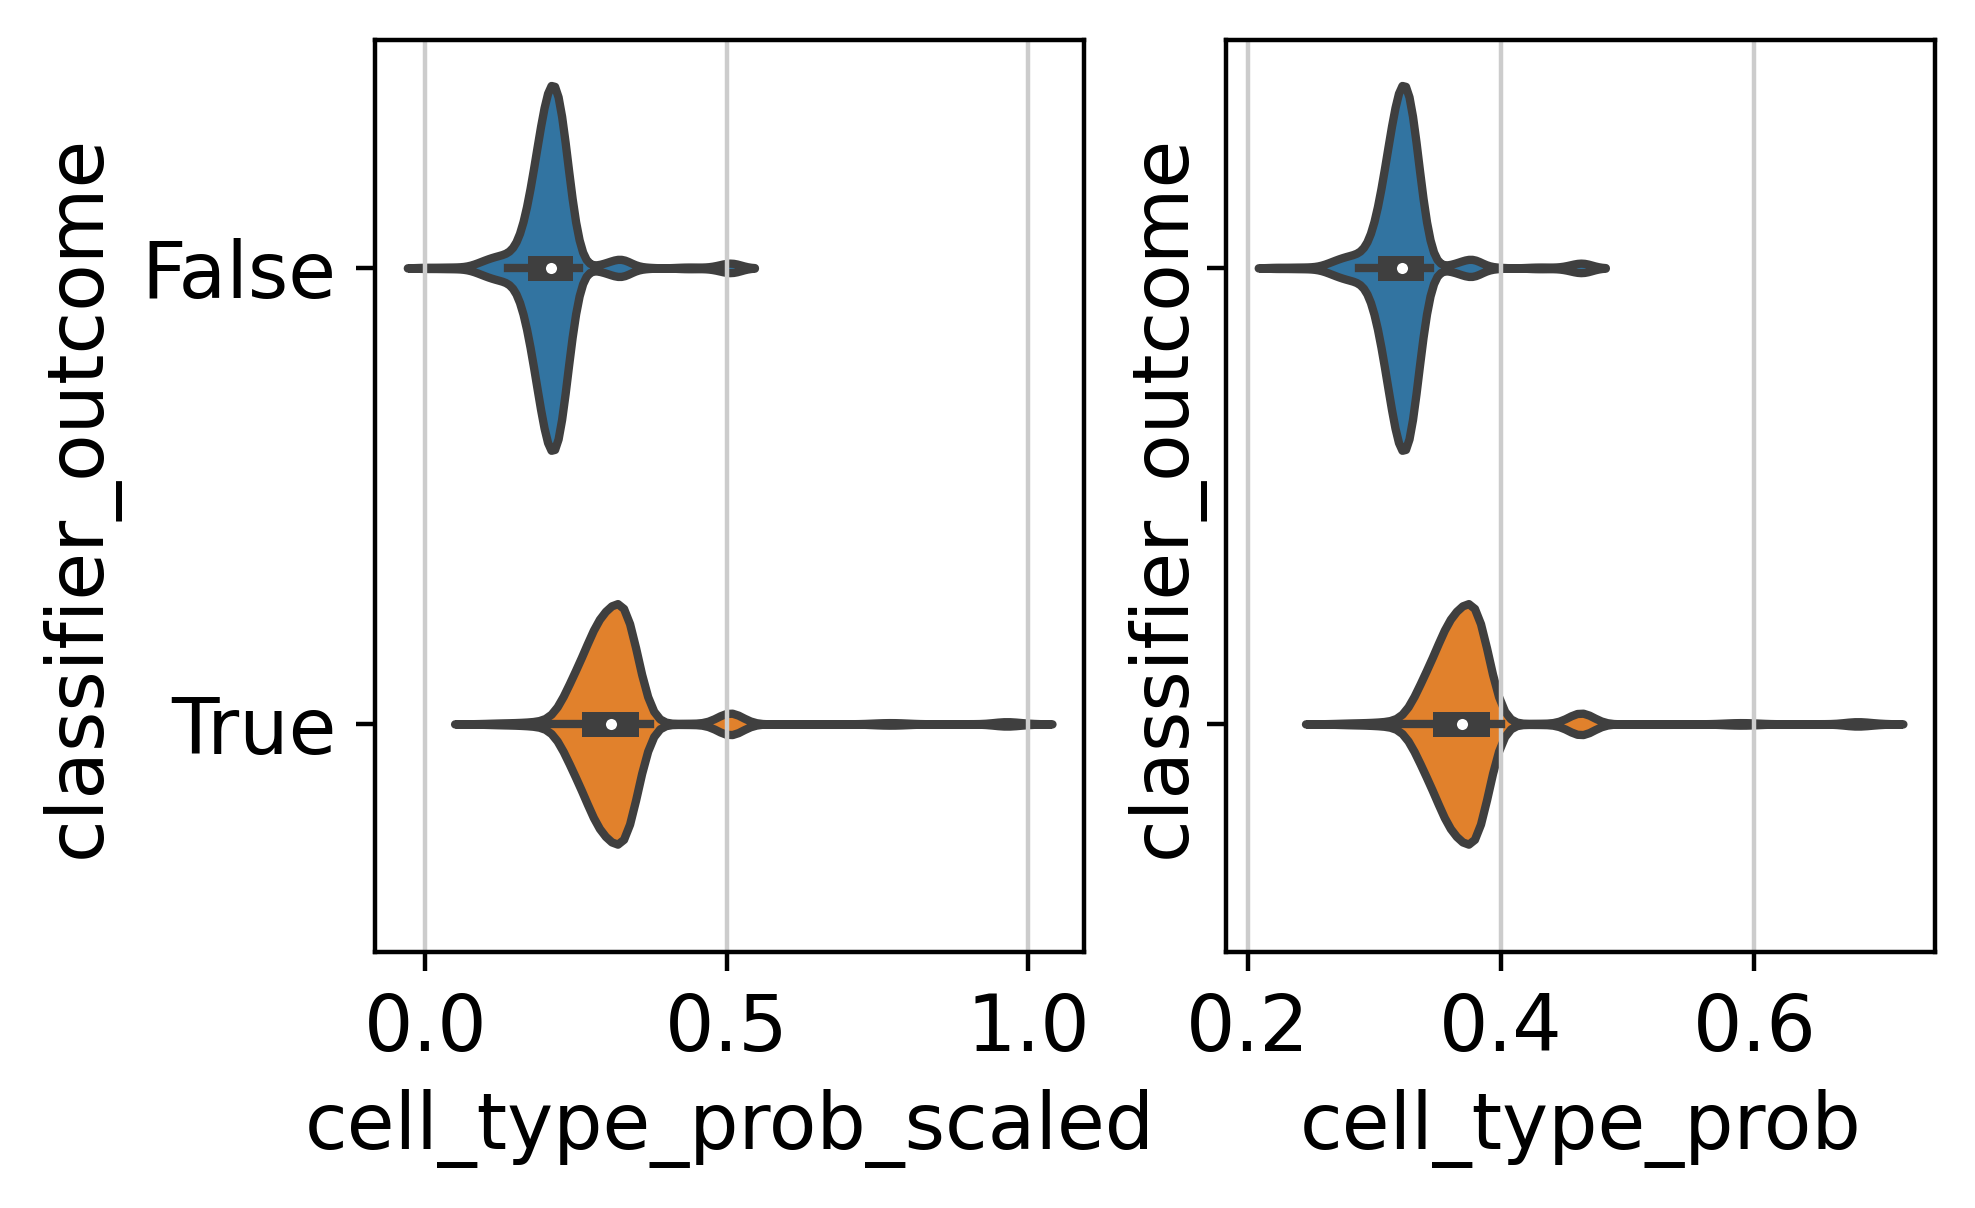

<Figure size 800x800 with 0 Axes>

In [277]:
fig, ax = plt.subplots(1, 2, figsize=(5, 3), sharey=True)
sns.violinplot(
    x=adata_latent.obs['cell_type_prob_scaled'], 
    y=adata_latent.obs['classifier_outcome'].astype('category'),
    ax=ax[0]
)
plt.figure()
sns.violinplot(
    x=adata_latent.obs['cell_type_prob'], 
    y=adata_latent.obs['classifier_outcome'].astype('category'),
    ax=ax[1]
)
plt.tight_layout()

(0.0, 1.0)

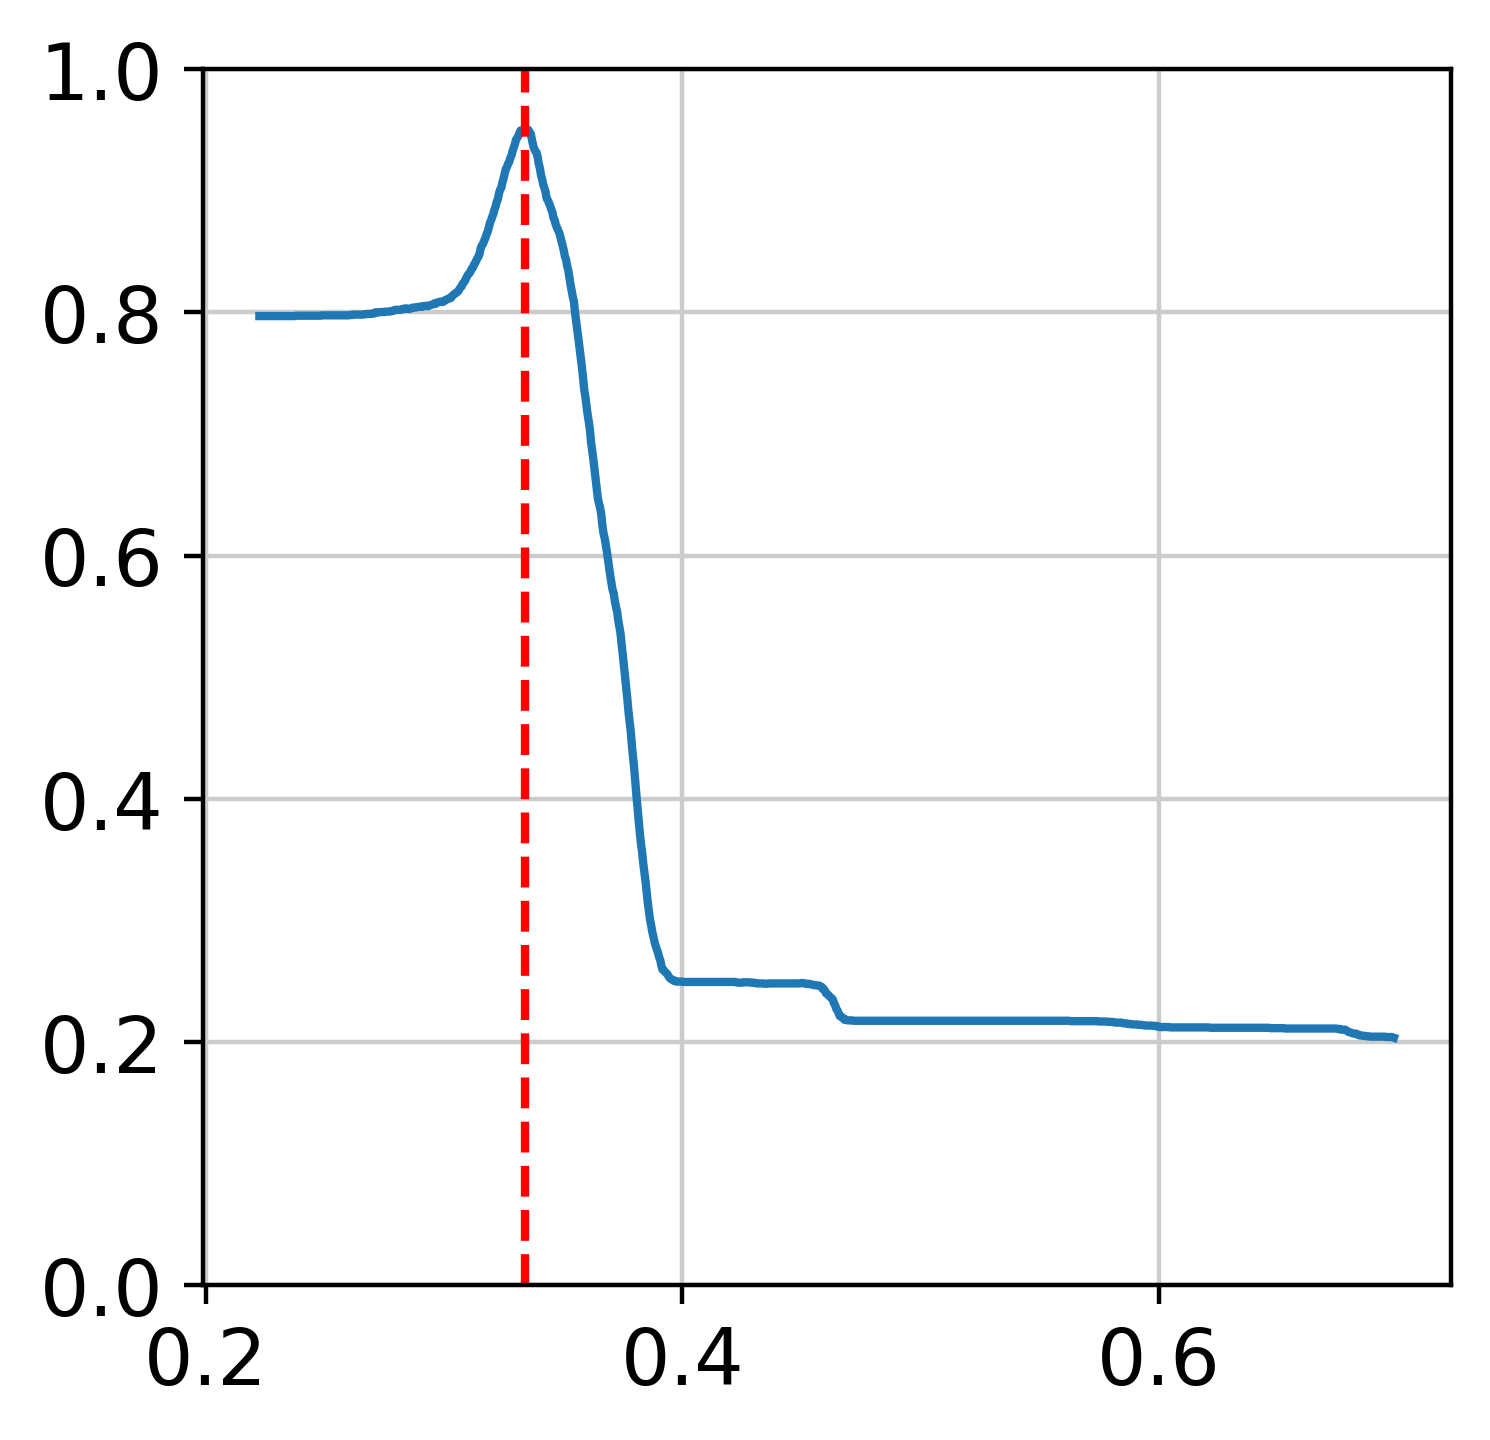

In [278]:
accs, candidates = detect_threshold(adata_latent.obs['cell_type_prob'], adata_latent.obs['classifier_outcome'])
candidates[np.argmax(accs)]
plt.plot(candidates, accs)
plt.axvline(candidates[np.argmax(accs)], color='r', linestyle='--')
plt.ylim([0, 1])

#### Get information for both landmark sets

In [279]:
labeled_set_euclidean = lataq.get_landmarks_info()
labeled_set_euclidean.obs['study'] = 'labeled landmark euclidean'

In [280]:
unlabeled_set_euclidean = lataq.get_landmarks_info(landmark_set='unlabeled')
unlabeled_set_euclidean.obs['study'] = 'unlabeled landmark euclidean'

#### Create adata object with cell  and landmark informations

In [281]:
data_latent = lataq.get_latent(mean=True)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs[condition_key] = query_adata.obs[condition_key].tolist()
adata_latent.obs[cell_type_key] = query_adata.obs[cell_type_key].tolist()
adata_latent.obs[f'{cell_type_key}_pred'] = preds_q.tolist()
adata_latent.obs[f'{cell_type_key}_prob'] = probs_q.tolist()
adata_latent.obs[f'classifier_outcome'] = (
    adata_latent.obs[f'{cell_type_key}_pred'] == adata_latent.obs[f'{cell_type_key}']
)
probs_scaled = (probs_q - probs_q.min(axis=0)) / (probs_q.max(axis=0) - probs_q.min(axis=0))
adata_latent.obs[f'{cell_type_key}_prob_scaled'] = probs_scaled
adata_latent

AnnData object with n_obs × n_vars = 3289 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob', 'classifier_outcome', 'cell_type_prob_scaled'

In [282]:
full_latent = adata_latent.concatenate([
    labeled_set_euclidean, 
    unlabeled_set_euclidean,
])
full_latent

AnnData object with n_obs × n_vars = 3327 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob', 'classifier_outcome', 'cell_type_prob_scaled', 'batch'

#### Visualize Combined adata object

In [283]:
sc.pp.pca(full_latent)
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'study' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_pred' as categorical


<AxesSubplot:title={'center':'classifier_outcome'}, xlabel='UMAP1', ylabel='UMAP2'>

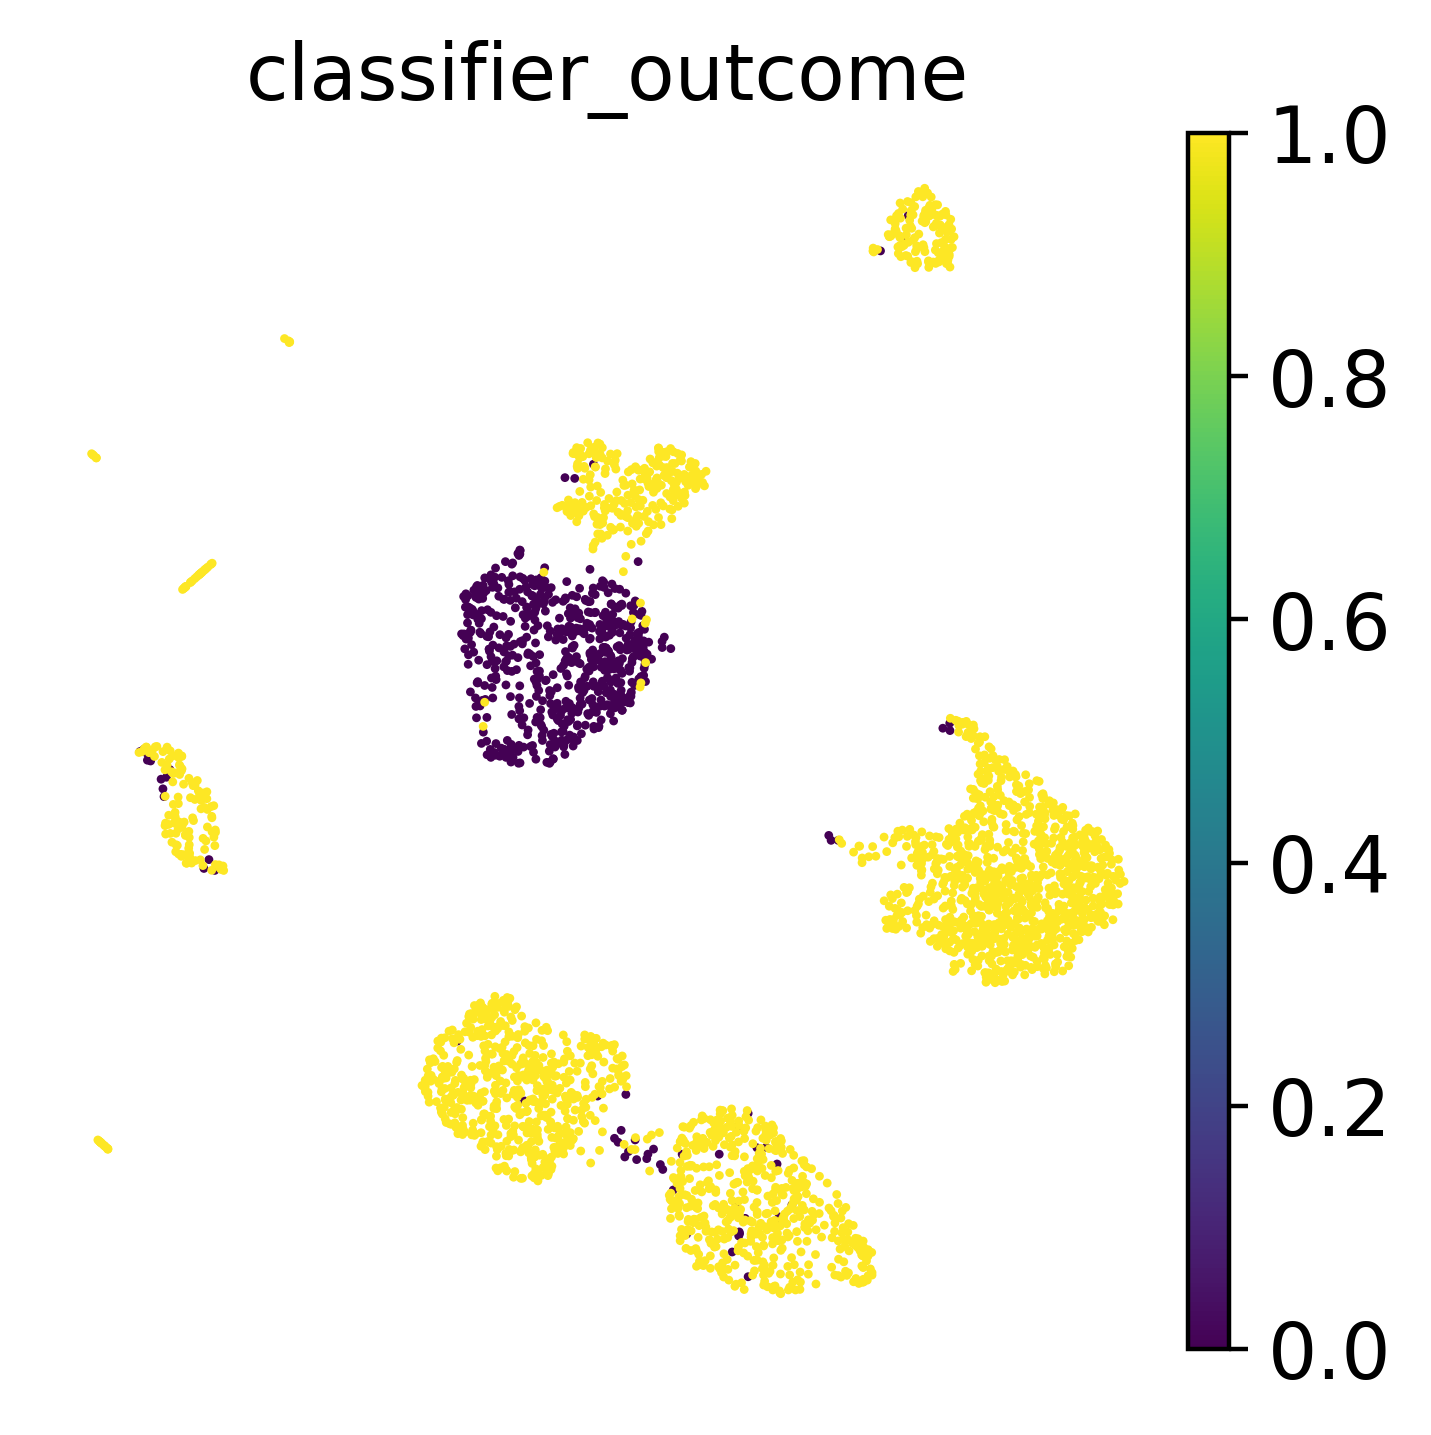

In [284]:
landmark_keys = [
    "labeled landmark euclidean",
    "unlabeled landmark euclidean"
]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
full_latent.obs['classifier_outcome'] = full_latent.obs['classifier_outcome'].astype('ca')
sc.pl.umap(
    full_latent[~full_latent.obs[condition_key].isin(landmark_keys)],
    size=10,
    color=['classifier_outcome'],
    frameon=False,
    show=False,
    ax=ax,
)

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'study' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_pred' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'study' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_pred' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'study' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_pred' as categorical
Trying to set attribu

cell_type
cell_type_pred
cell_type_prob
cell_type_prob_scaled


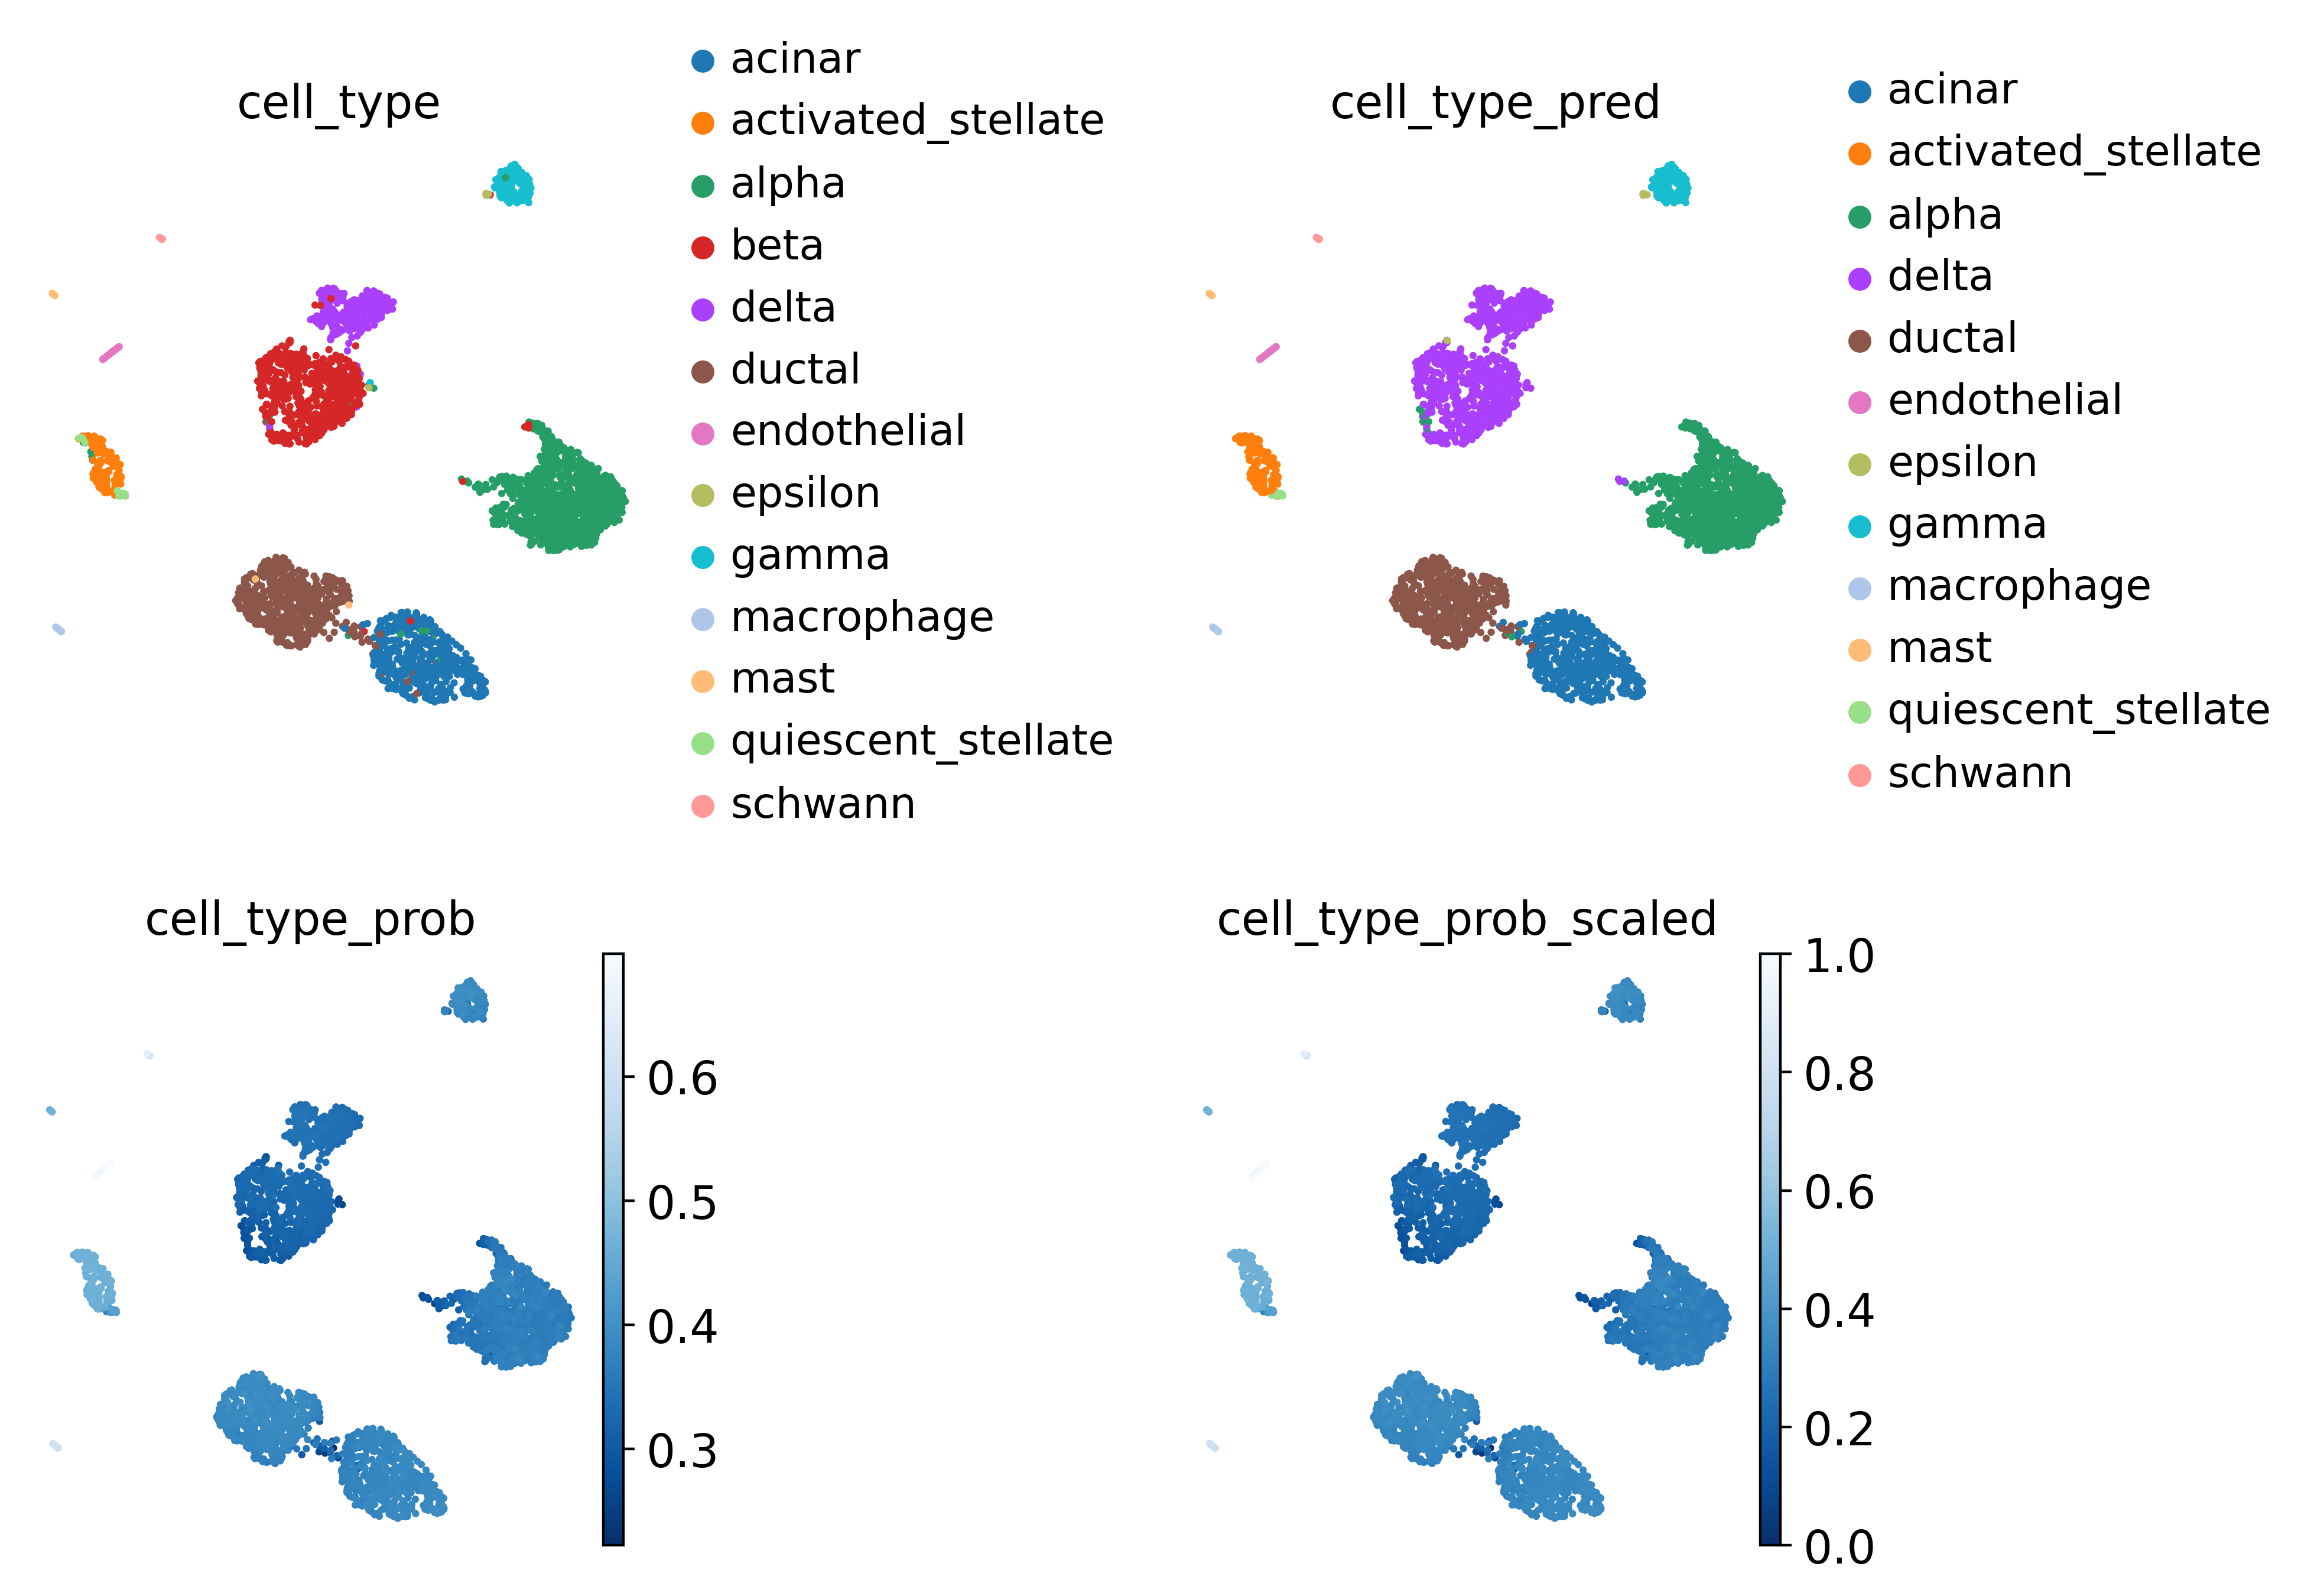

In [285]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax = ax.flatten()
plot_keys = [
    'cell_type', 
    'cell_type_pred',
    'cell_type_prob',
    'cell_type_prob_scaled'
]
sc.pp.pca(full_latent)
for i, key in enumerate(plot_keys):
    print(key)
    palette = cell_type_coldict
    cmap = None
    if i > 1:
        cmap='Blues_r'
        palette = None
    sc.pl.umap(
        full_latent[~full_latent.obs[condition_key].isin(landmark_keys)], 
        color=key,
        size=20,
        show=False, 
        ax=ax[i],
        frameon=False,
        cmap=cmap,
        palette=palette
    )
    ax[i].set_title(key)
fig.tight_layout()

... storing 'study' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_pred' as categorical
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


labeled landmark euclidean
unlabeled landmark euclidean


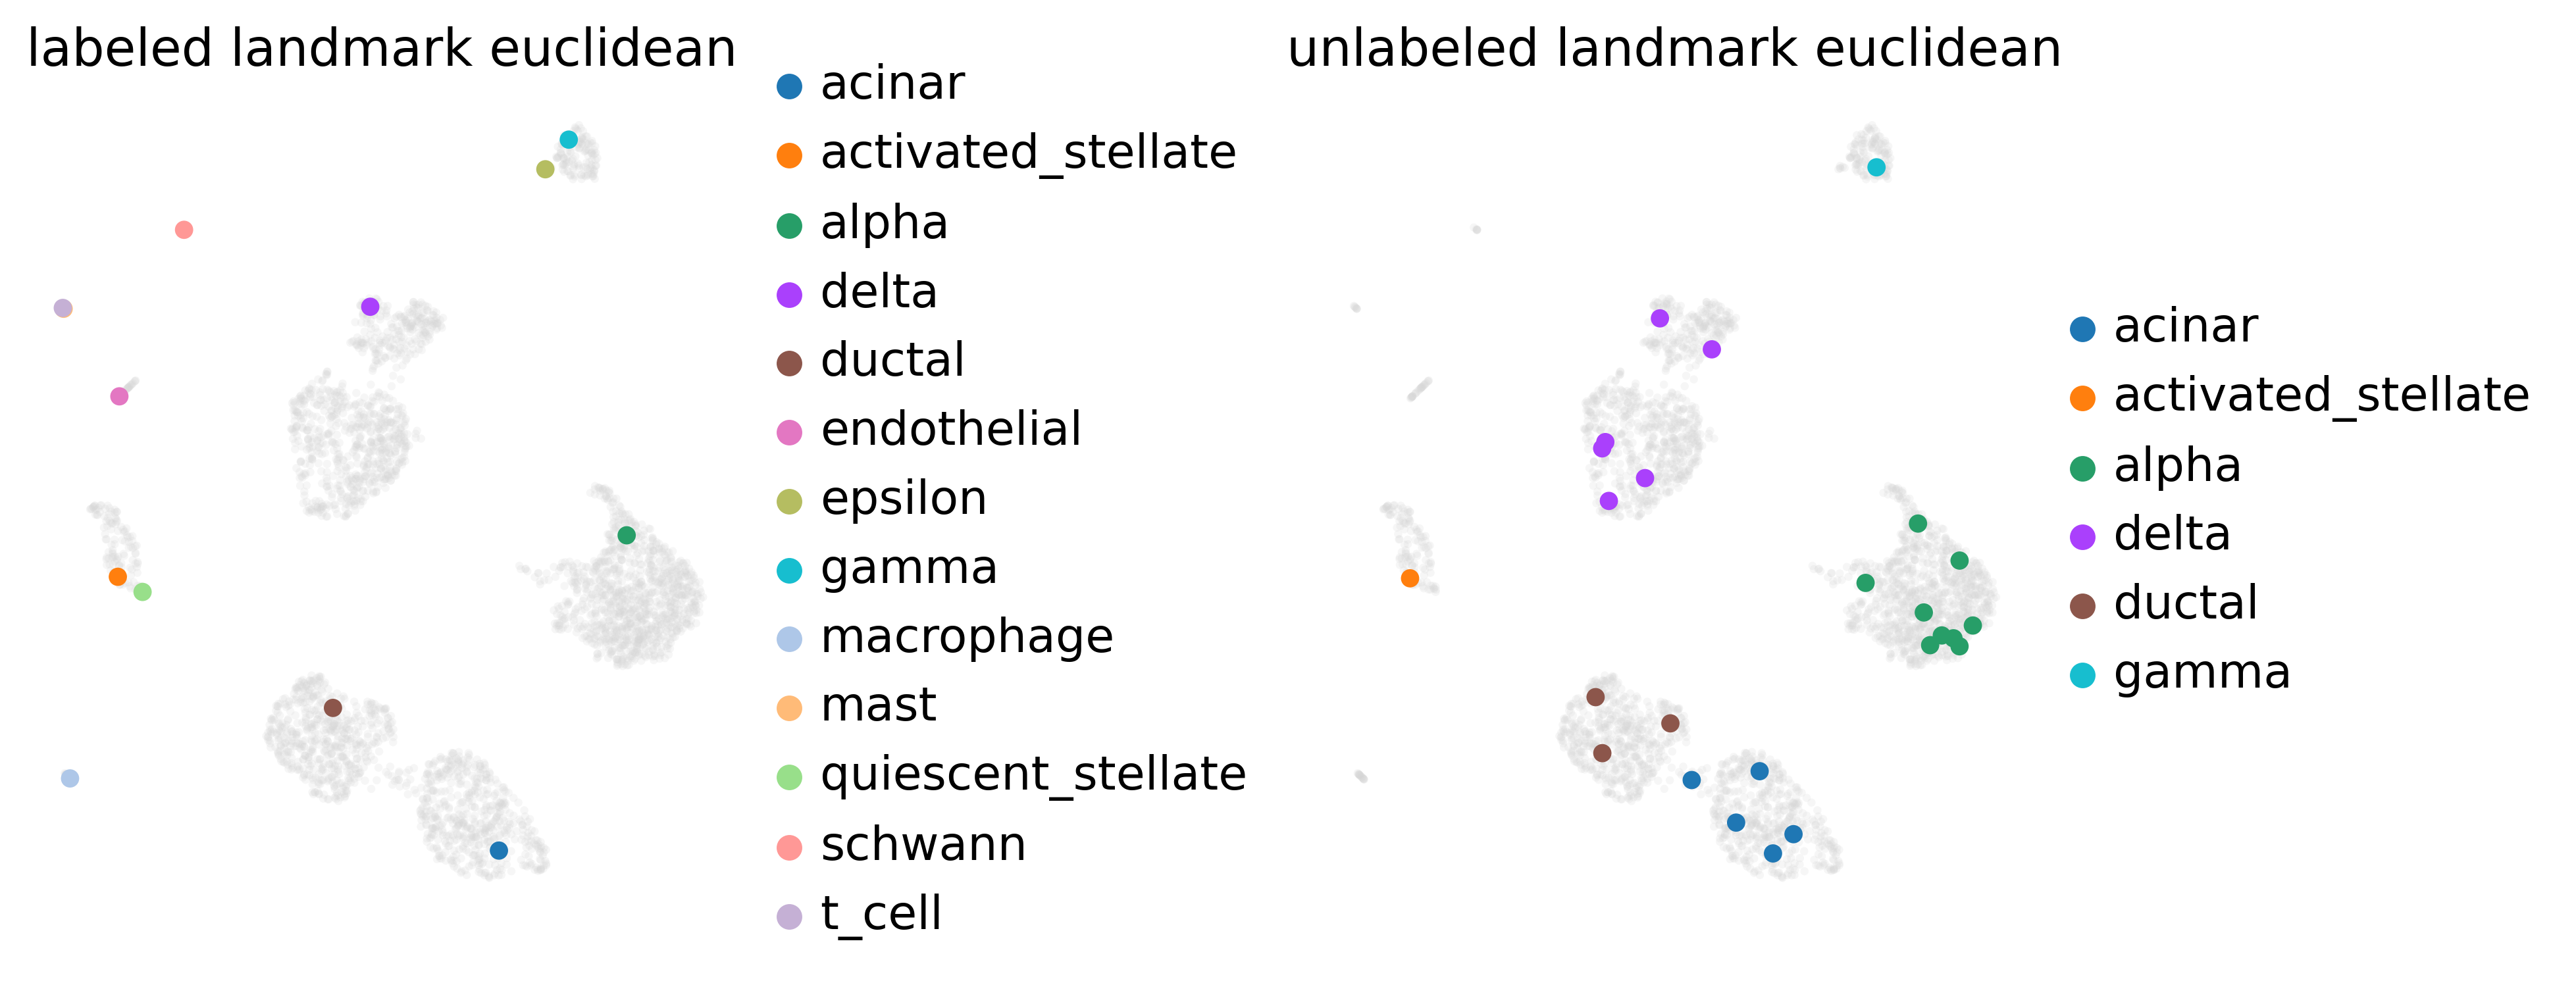

In [237]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.flatten()
sc.pp.pca(full_latent)
for i, key in enumerate(landmark_keys):
    print(key)
    sc.pl.umap(
        full_latent, 
        #color=cell_type_key,
        size=20,
        alpha=0.2, 
        show=False, 
        palette=cell_type_coldict,
        ax=ax[i]
    )
    ax[i].legend([])
    sc.pl.umap(
        full_latent[full_latent.obs[condition_key] == key],
        size=100,
        color=[cell_type_key + '_pred'],
        ax=ax[i],
        show=False,
        palette=cell_type_coldict,
        frameon=False,
    )
    ax[i].set_title(key)
fig.tight_layout()

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


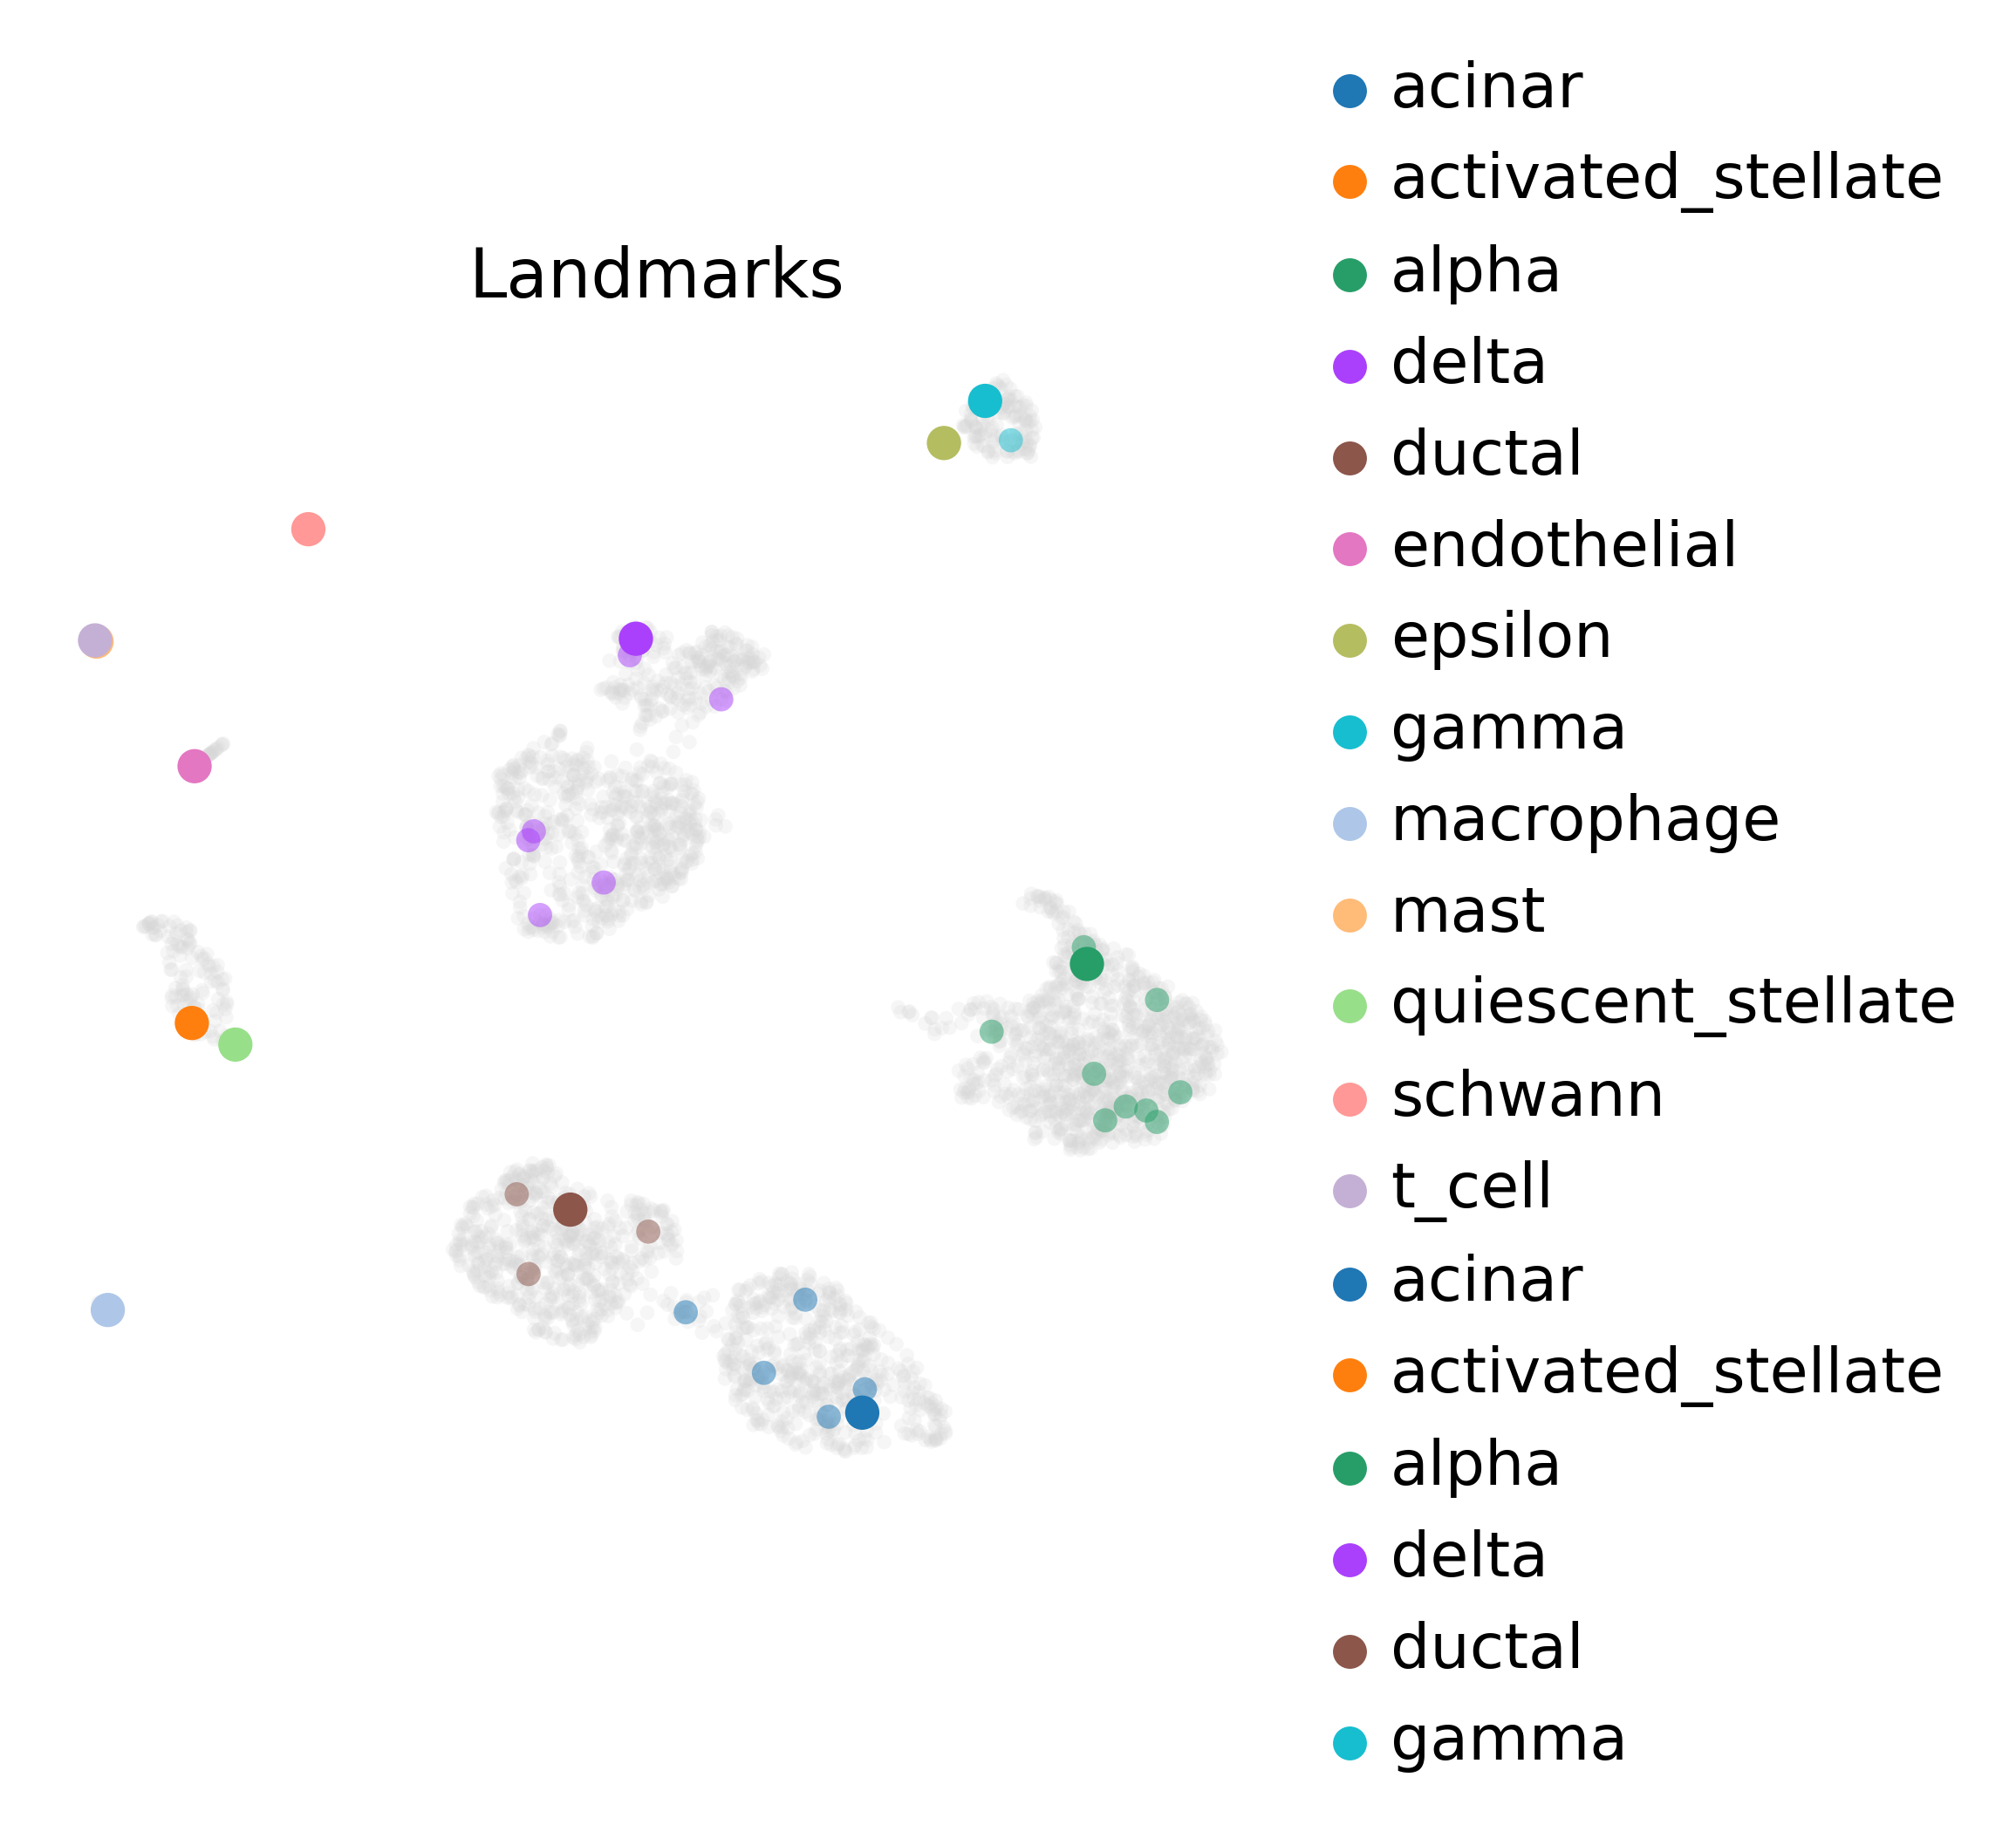

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sc.pl.umap(
    full_latent, 
    #color=cell_type_key,
    alpha=0.2, 
    show=False, 
    palette=cell_type_coldict,
    ax=ax
)
ax.legend([])
sc.pl.umap(
    full_latent[full_latent.obs[condition_key] == 'labeled landmark euclidean'],
    size=200,
    color=[cell_type_key + '_pred'],
    ax=ax,
    show=False,
    palette=cell_type_coldict,
    frameon=False,
)
sc.pl.umap(
    full_latent[full_latent.obs[condition_key] == 'unlabeled landmark euclidean'],
    size=100,
    color=[cell_type_key + '_pred'],
    ax=ax,
    show=False,
    palette=cell_type_coldict,
    frameon=False,
    alpha=0.5,
)
ax.set_title('Landmarks')
fig.tight_layout()

Trying to set attribute `.uns` of view, copying.


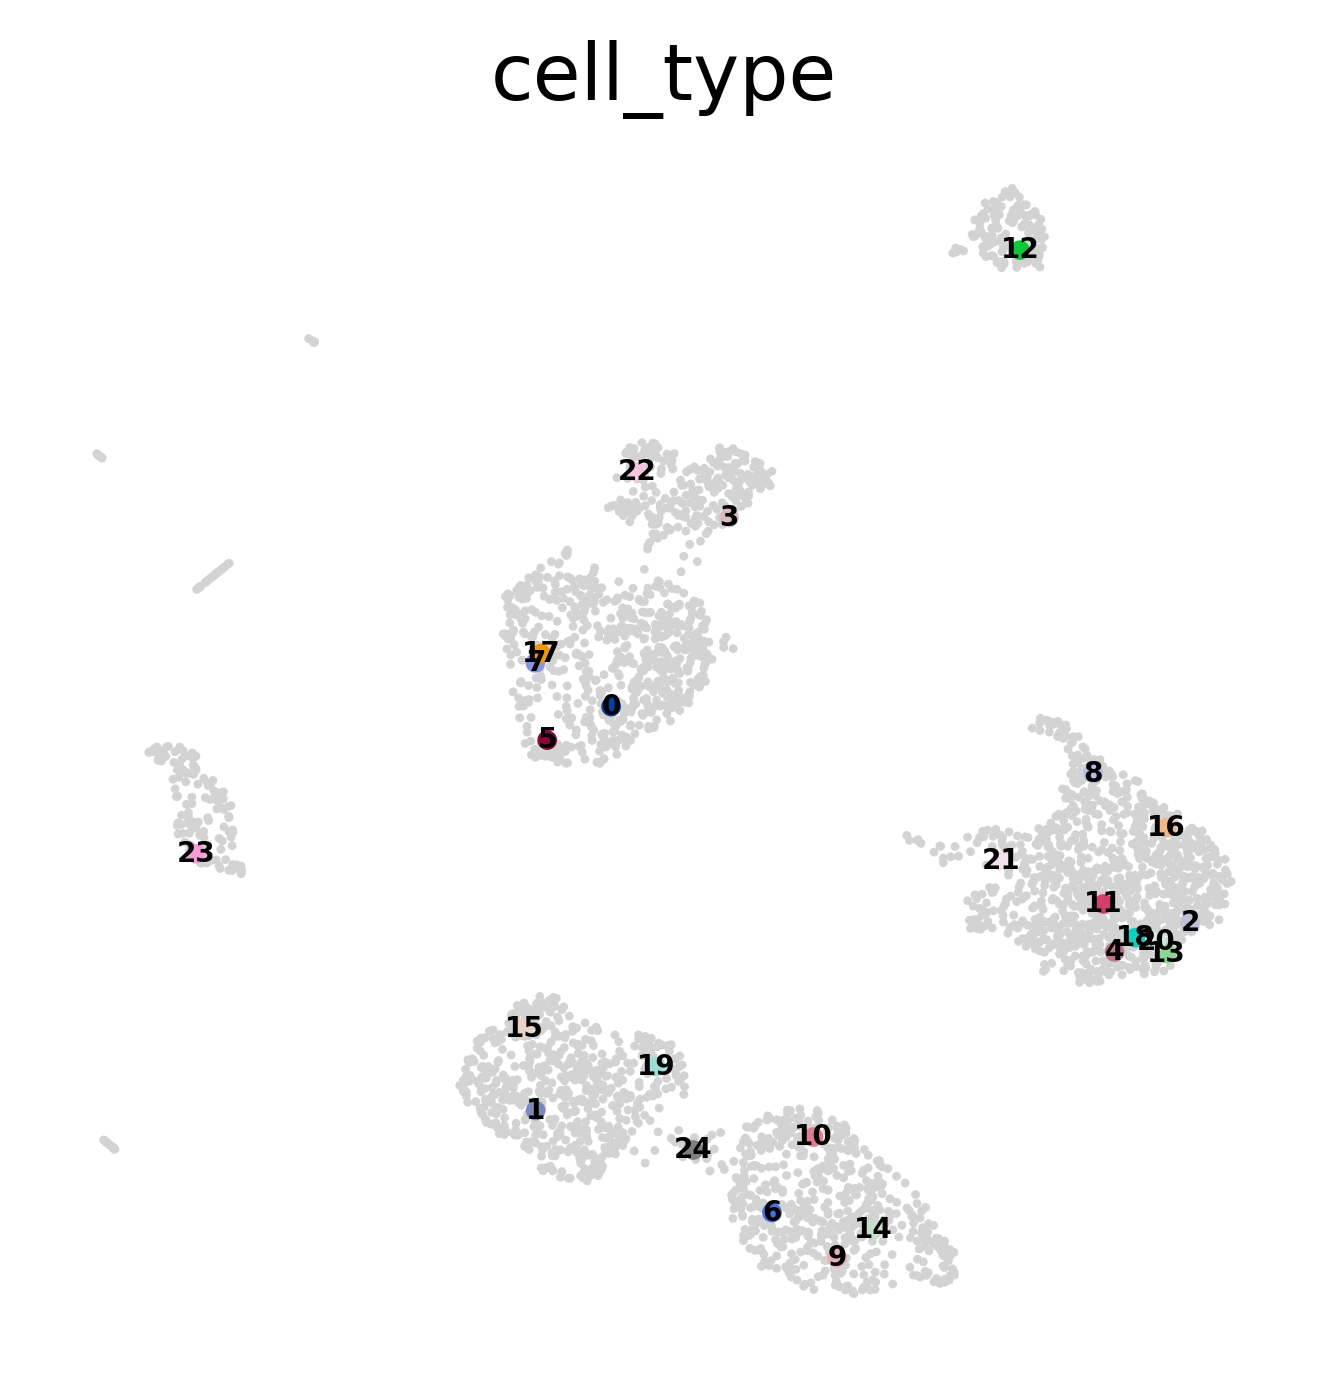

In [239]:
ax = sc.pl.umap(full_latent, size=10, show=False)
sc.pl.umap(
    full_latent[full_latent.obs[condition_key] == "unlabeled landmark euclidean"],
    size=50,
    color=[cell_type_key],
    frameon=False,
    ax=ax,
    legend_loc='on data',
    legend_fontsize=5,
)

# Unseen cell type detection

#### Check for novel cell types

In [240]:
THRESHOLD = 0.32
unlabeled_set_euclidean.obs['novel'] = (unlabeled_set_euclidean.obs['cell_type_prob'] < THRESHOLD)

In [241]:
full_latent = adata_latent.concatenate([
    labeled_set_euclidean, 
    unlabeled_set_euclidean,
])
full_latent.obs['novel'] = full_latent.obs['novel'].astype('category')

In [242]:
sc.pp.pca(full_latent)
sc.pp.neighbors(full_latent)
sc.tl.umap(full_latent)

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'study' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_pred' as categorical


KeyError: "Could not find entry in `obsm` for 'umap'.\nAvailable keys are: []."

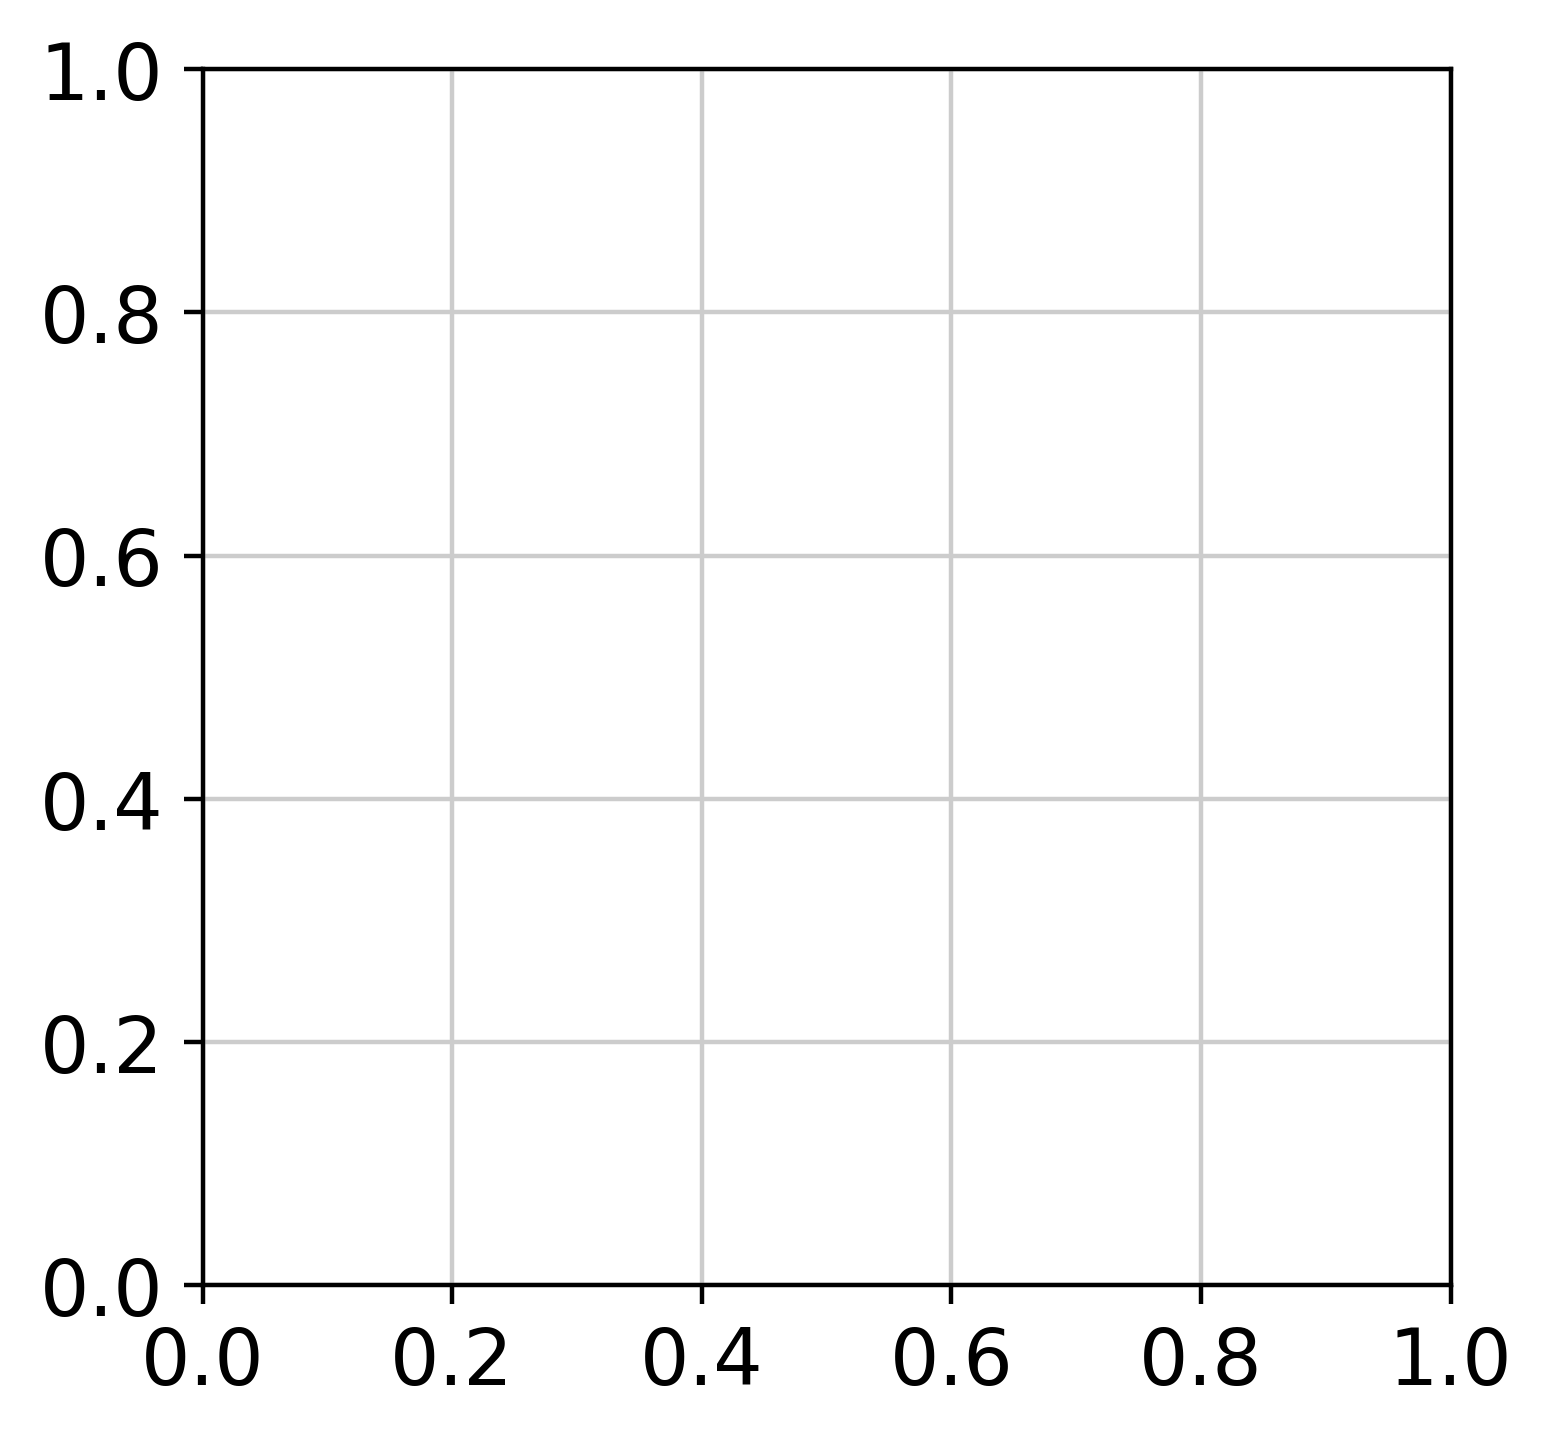

In [264]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.umap(
    full_latent[~full_latent.obs[condition_key].isin([
        "unlabeled landmark euclidean",
        "labeled landmark euclidean"
    ])], 
    size=10, 
    show=False, 
    frameon=False,
    color='cell_type',
    alpha=0.5,
    palette=cell_type_coldict,
    ax=ax
)
#sc.pl.umap(
#    full_latent[full_latent.obs[condition_key] == "unlabeled landmark euclidean"],
#    size=0,
#    color=cell_type_key,
#    ax=ax,
#    show=False,
#    frameon=False,
#    legend_loc='on data',
#    legend_fontsize=5,
#    alpha=0,
#)
sc.pl.umap(
    full_latent[
        (full_latent.obs[condition_key] == "unlabeled landmark euclidean")
        & (full_latent.obs['novel'] == False)
    ],
    size=1,
    show=False,
    frameon=False,
    color='cell_type',
    legend_loc='on data',
    ax=ax,
    legend_fontsize=5,
)
sc.pl.umap(
    full_latent[
        (full_latent.obs[condition_key] == "unlabeled landmark euclidean")
        & (full_latent.obs['novel'] == True)
    ],
    size=1,
    show=False,
    frameon=False,
    color='cell_type',
    legend_loc='on data',
    ax=ax,
    legend_fontsize=6,
    legend_fontoutline=1,
)

... storing 'study' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_pred' as categorical
Trying to set attribute `.uns` of view, copying.


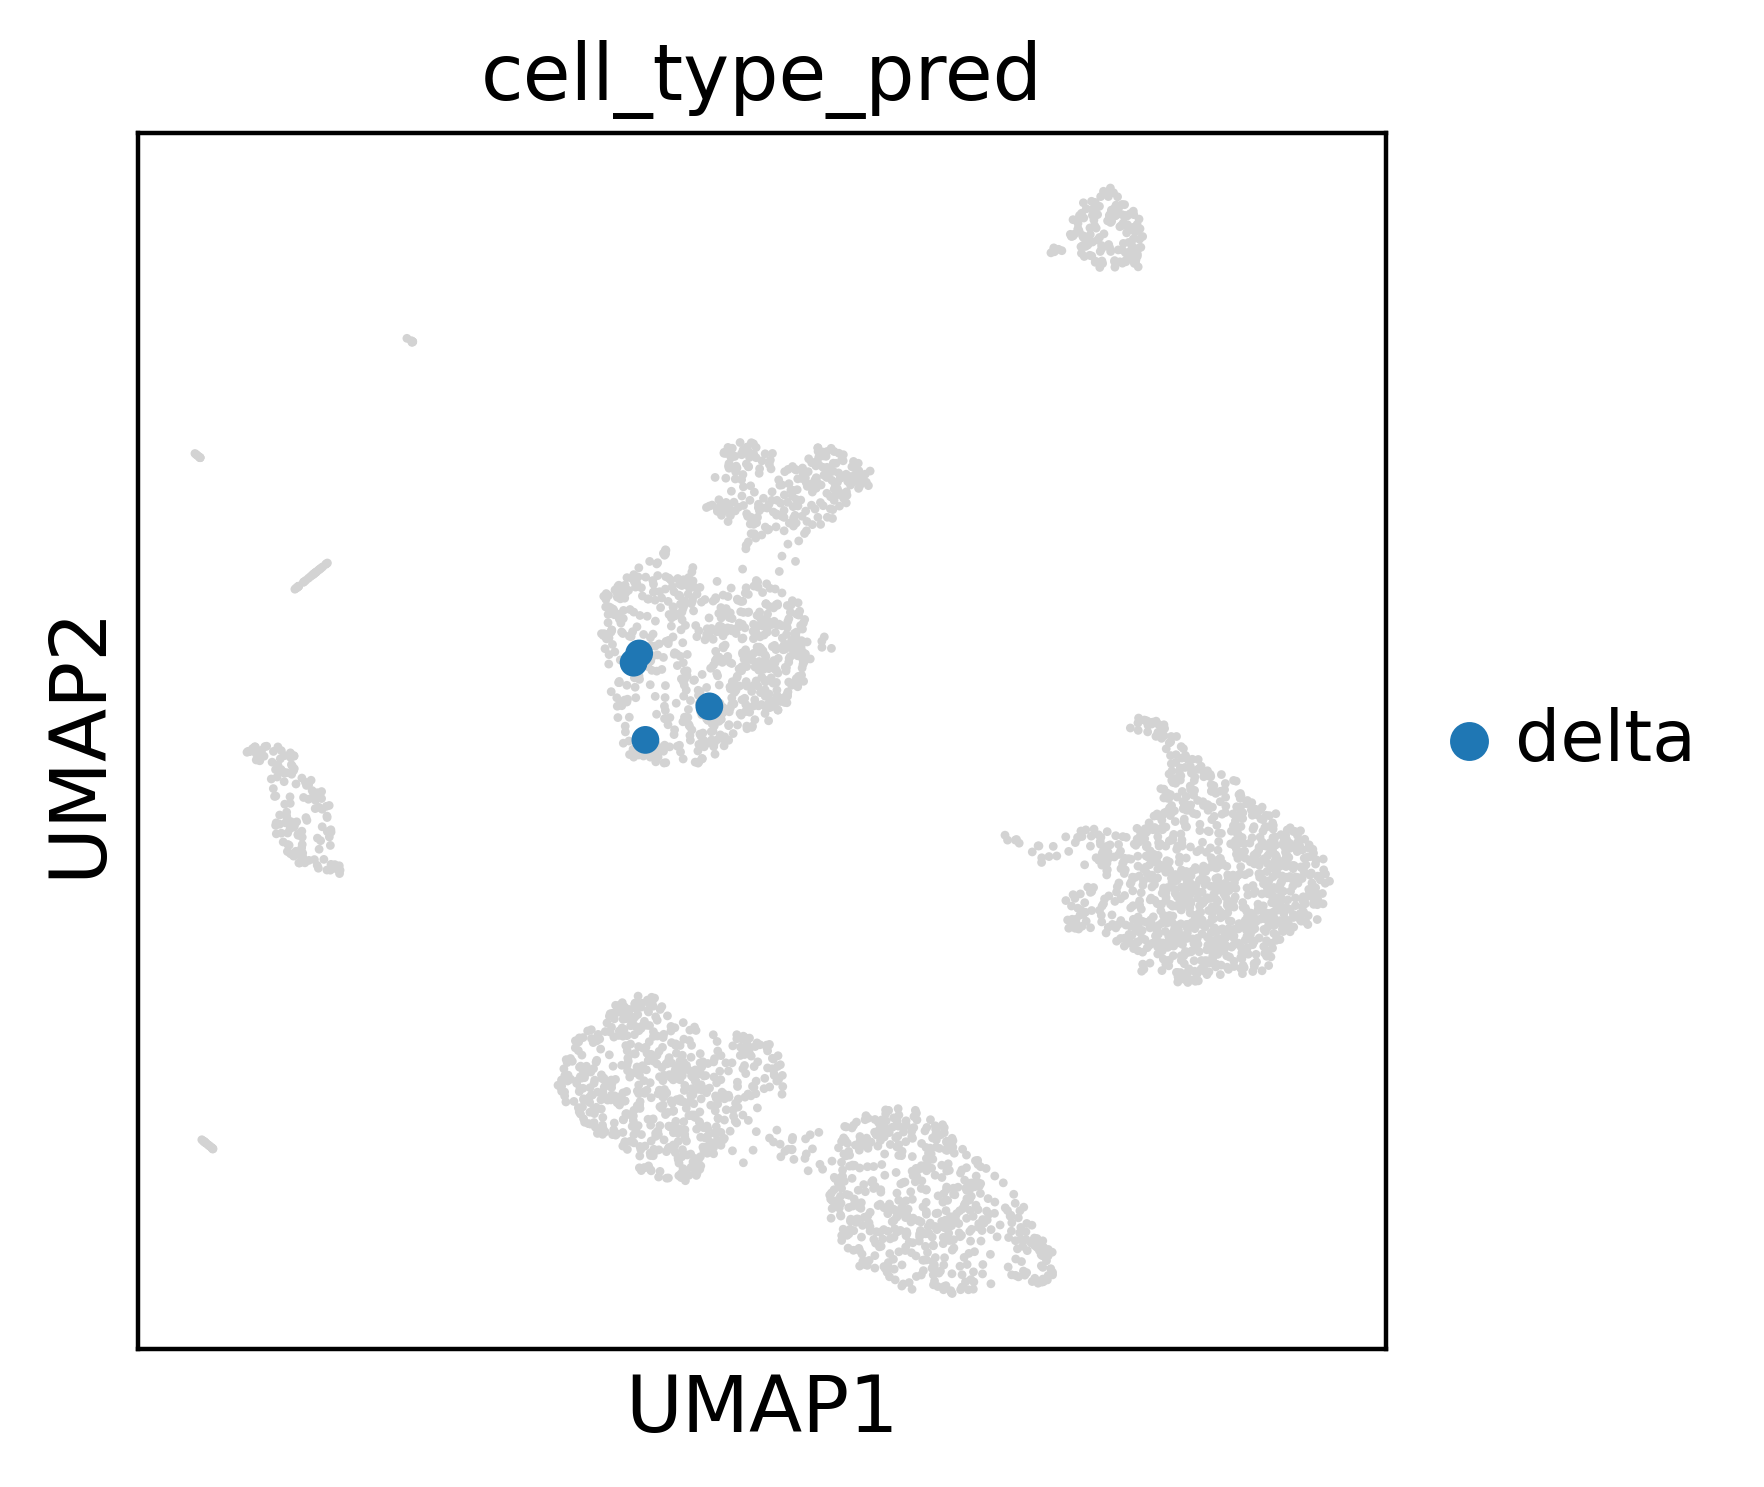

In [244]:
check = np.array([0, 5, 7, 17])
check_shifted = check + len(adata_latent) + len(labeled_set_euclidean)

ax = sc.pl.umap(full_latent, size=10, show=False)
sc.pl.umap(
    full_latent[check_shifted],
    size=100,
    color=[cell_type_key + '_pred'],
    ax=ax
)

#### Add novel cell type with corresponding landmark(s) to the model

In [245]:
lataq.add_new_cell_type(
    "beta", 
    cell_type_key, 
    check
)

# Visualize results with updated model

                    precision    recall  f1-score   support

             gamma       0.99      0.98      0.99       128
            acinar       0.95      0.99      0.97       502
             alpha       0.99      0.97      0.98      1034
             delta       0.82      0.97      0.89       253
              beta       0.95      0.90      0.92       606
            ductal       0.99      0.96      0.97       585
       endothelial       1.00      1.00      1.00        26
activated_stellate       0.89      0.99      0.94       109
           schwann       1.00      1.00      1.00         5
              mast       1.00      0.71      0.83         7
        macrophage       1.00      0.94      0.97        16
           epsilon       0.57      0.80      0.67         5
quiescent_stellate       0.86      0.46      0.60        13

          accuracy                           0.96      3289
         macro avg       0.92      0.90      0.90      3289
      weighted avg       0.96      0.9

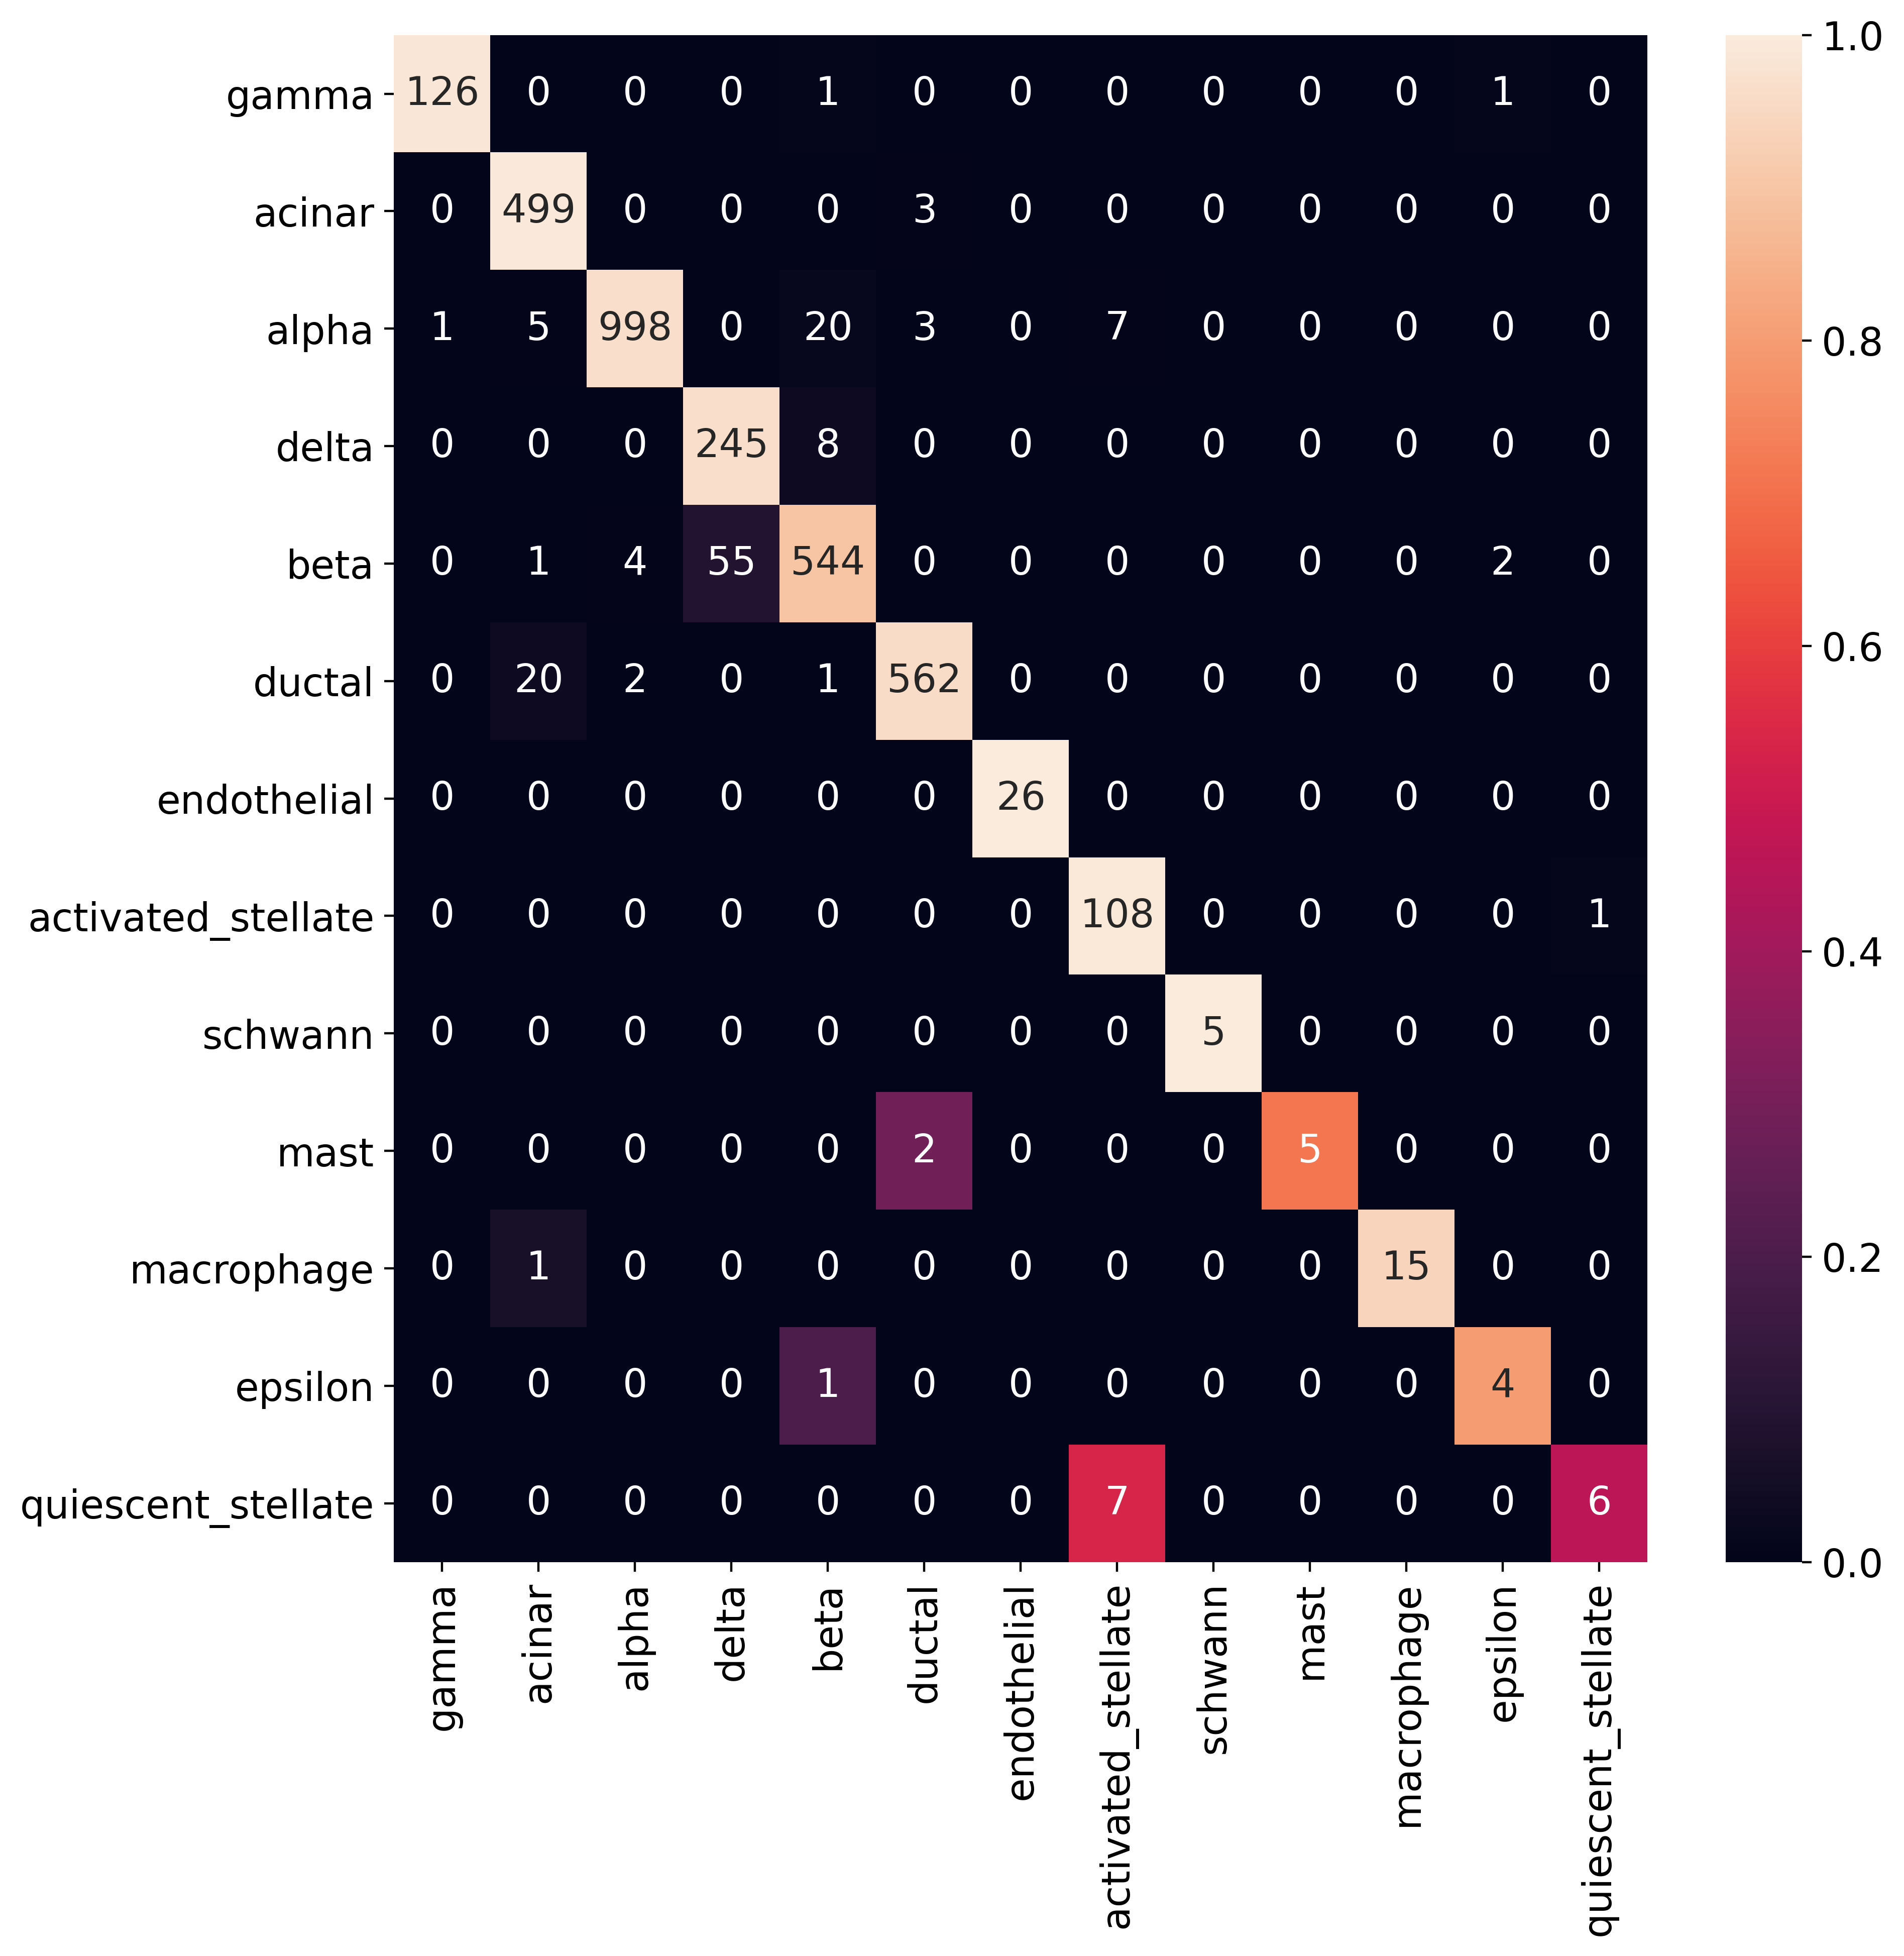

In [247]:
results_dict = lataq.classify(
    metric="dist",
    get_prob=True,
    threshold=-1e10
)

preds = results_dict[cell_type_key]['preds']
probs = results_dict[cell_type_key]['probs']
print(classification_report(
    y_true=query_adata.obs[cell_type_key],
    y_pred=preds,
    labels=np.array(query_adata.obs[cell_type_key].unique().tolist())
))
conf_matrix_plot(
    y_true=query_adata.obs[cell_type_key],
    y_pred=preds,
    labels=np.array(query_adata.obs[cell_type_key].unique().tolist())
)

In [248]:
labeled_set = lataq.get_landmarks_info(
)
unlabeled_set = lataq.get_landmarks_info(
    landmark_set='unlabeled',
)

In [261]:
results_dict = lataq.classify(
    query_adata.X,
    query_adata.obs[condition_key],
)

preds = results_dict[cell_type_key]['preds']
probs = results_dict[cell_type_key]['probs']
print(classification_report(
    y_true=query_adata.obs[cell_type_key],
    y_pred=preds,
    labels=np.array(query_adata.obs[cell_type_key].unique().tolist())
))
data_latent = lataq.get_latent(
    query_adata.X,
    query_adata.obs[condition_key],
    mean=True
)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs[condition_key] = query_adata.obs[condition_key].tolist()
adata_latent.obs[cell_type_key] = query_adata.obs[cell_type_key].tolist()
adata_latent.obs[f'{cell_type_key}_pred'] = preds.tolist()
adata_latent.obs[f'{cell_type_key}_prob'] = probs.tolist()
adata_latent.obs[f'classifier_outcome'] = (
    adata_latent.obs[f'{cell_type_key}_pred'] == adata_latent.obs[f'{cell_type_key}']
).astype('category')
full_latent = adata_latent.concatenate(labeled_set, unlabeled_set)

                    precision    recall  f1-score   support

             gamma       0.99      0.98      0.99       128
            acinar       0.95      1.00      0.97       502
             alpha       0.99      0.97      0.98      1034
             delta       0.82      0.97      0.89       253
              beta       0.95      0.90      0.92       606
            ductal       0.99      0.96      0.97       585
       endothelial       1.00      1.00      1.00        26
activated_stellate       0.89      0.99      0.94       109
           schwann       1.00      1.00      1.00         5
              mast       1.00      0.71      0.83         7
        macrophage       1.00      0.94      0.97        16
           epsilon       0.57      0.80      0.67         5
quiescent_stellate       0.86      0.46      0.60        13

          accuracy                           0.96      3289
         macro avg       0.92      0.90      0.90      3289
      weighted avg       0.96      0.9

In [262]:
sc.pp.neighbors(adata_latent)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)

<AxesSubplot:title={'center':'cell_type_pred'}, xlabel='UMAP1', ylabel='UMAP2'>

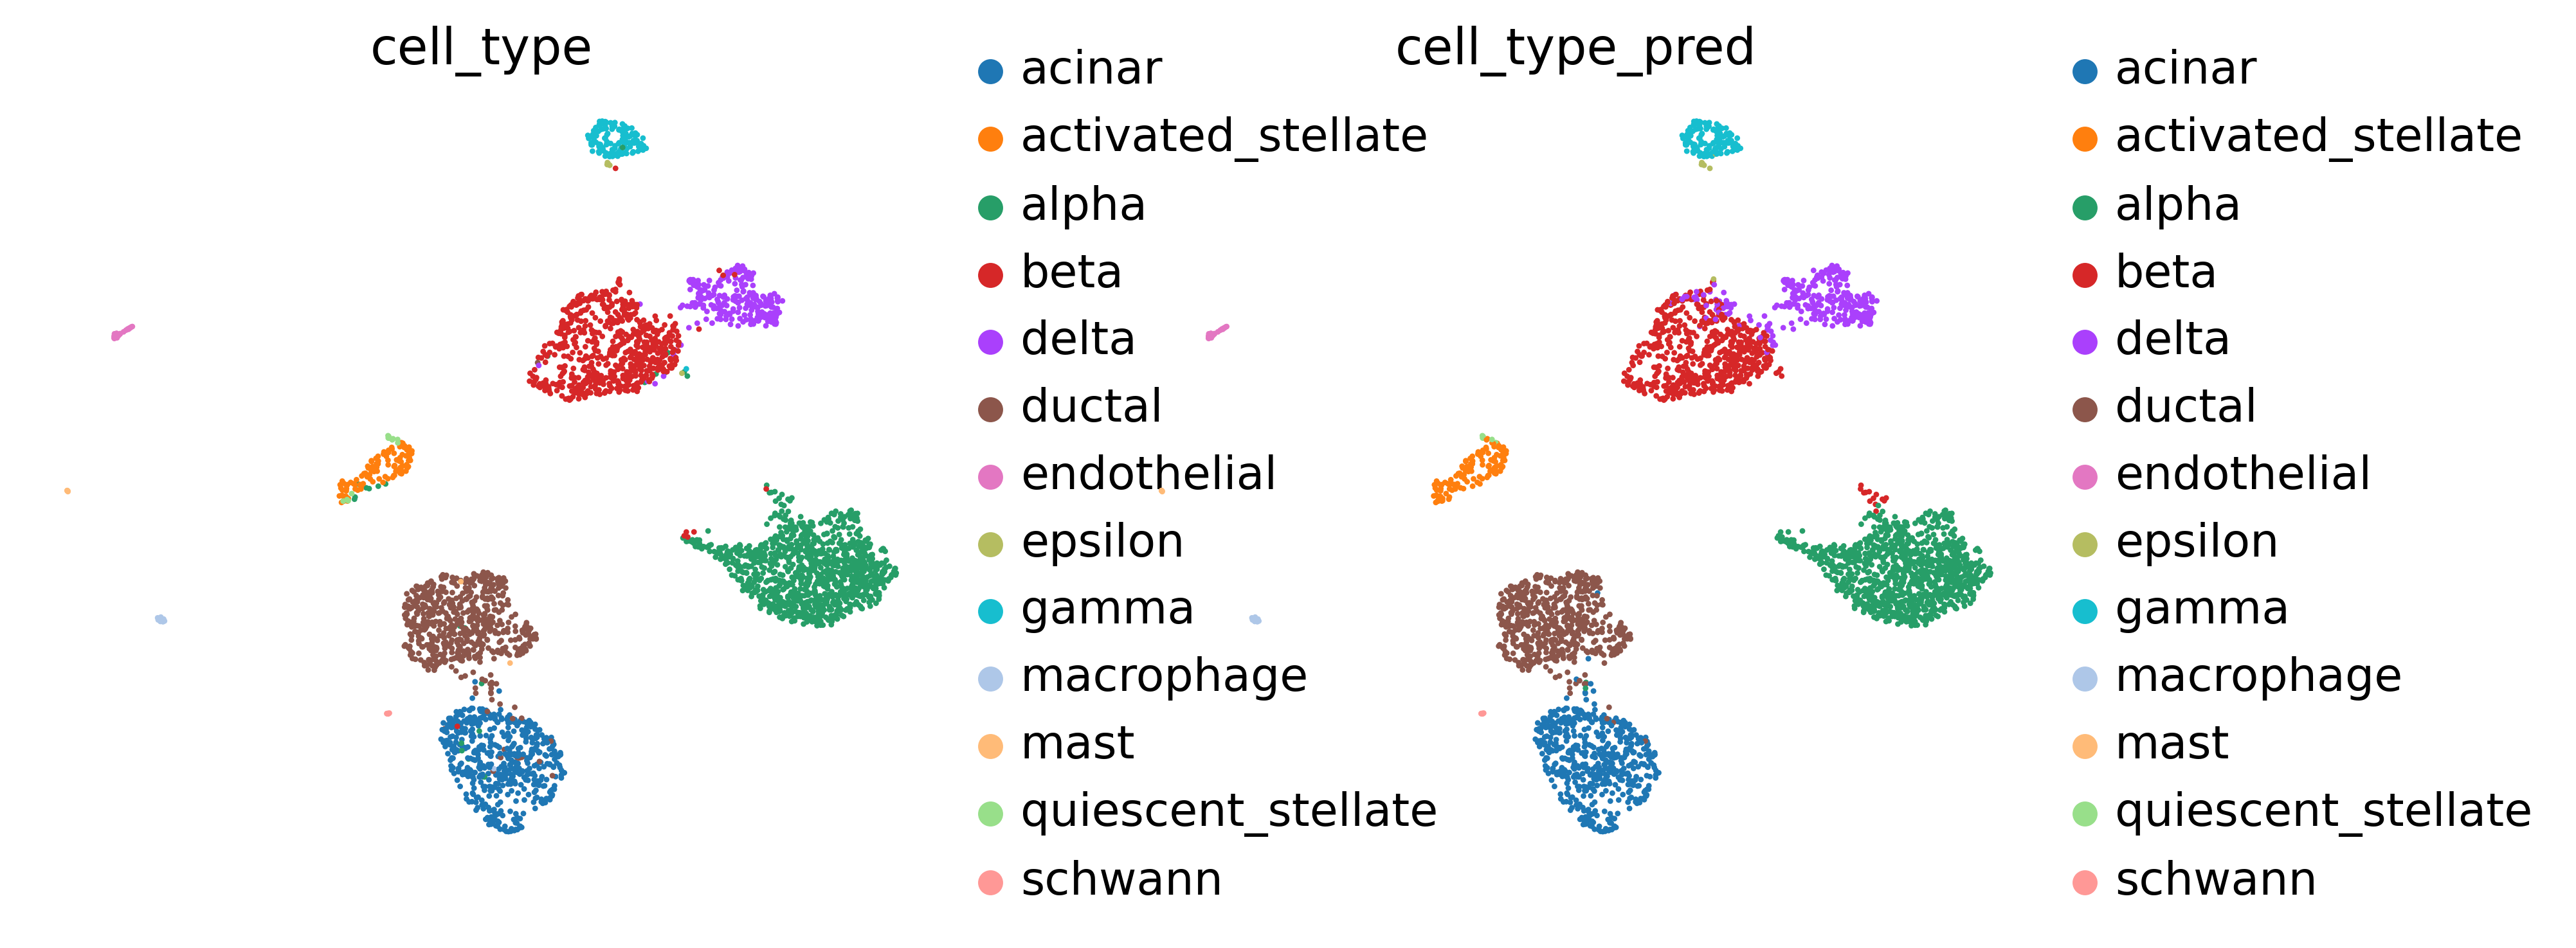

In [268]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sc.pl.umap(
    adata_latent,
    wspace=1,
    size=10,
    color=[cell_type_key],
    frameon=False,
    show=False,
    ax=ax[0]
)
sc.pl.umap(
    adata_latent,
    size=10,
    color=['cell_type_pred'],
    frameon=False,
    show=False,
    ax=ax[1]
)

<AxesSubplot:title={'center':'classifier_outcome'}, xlabel='UMAP1', ylabel='UMAP2'>

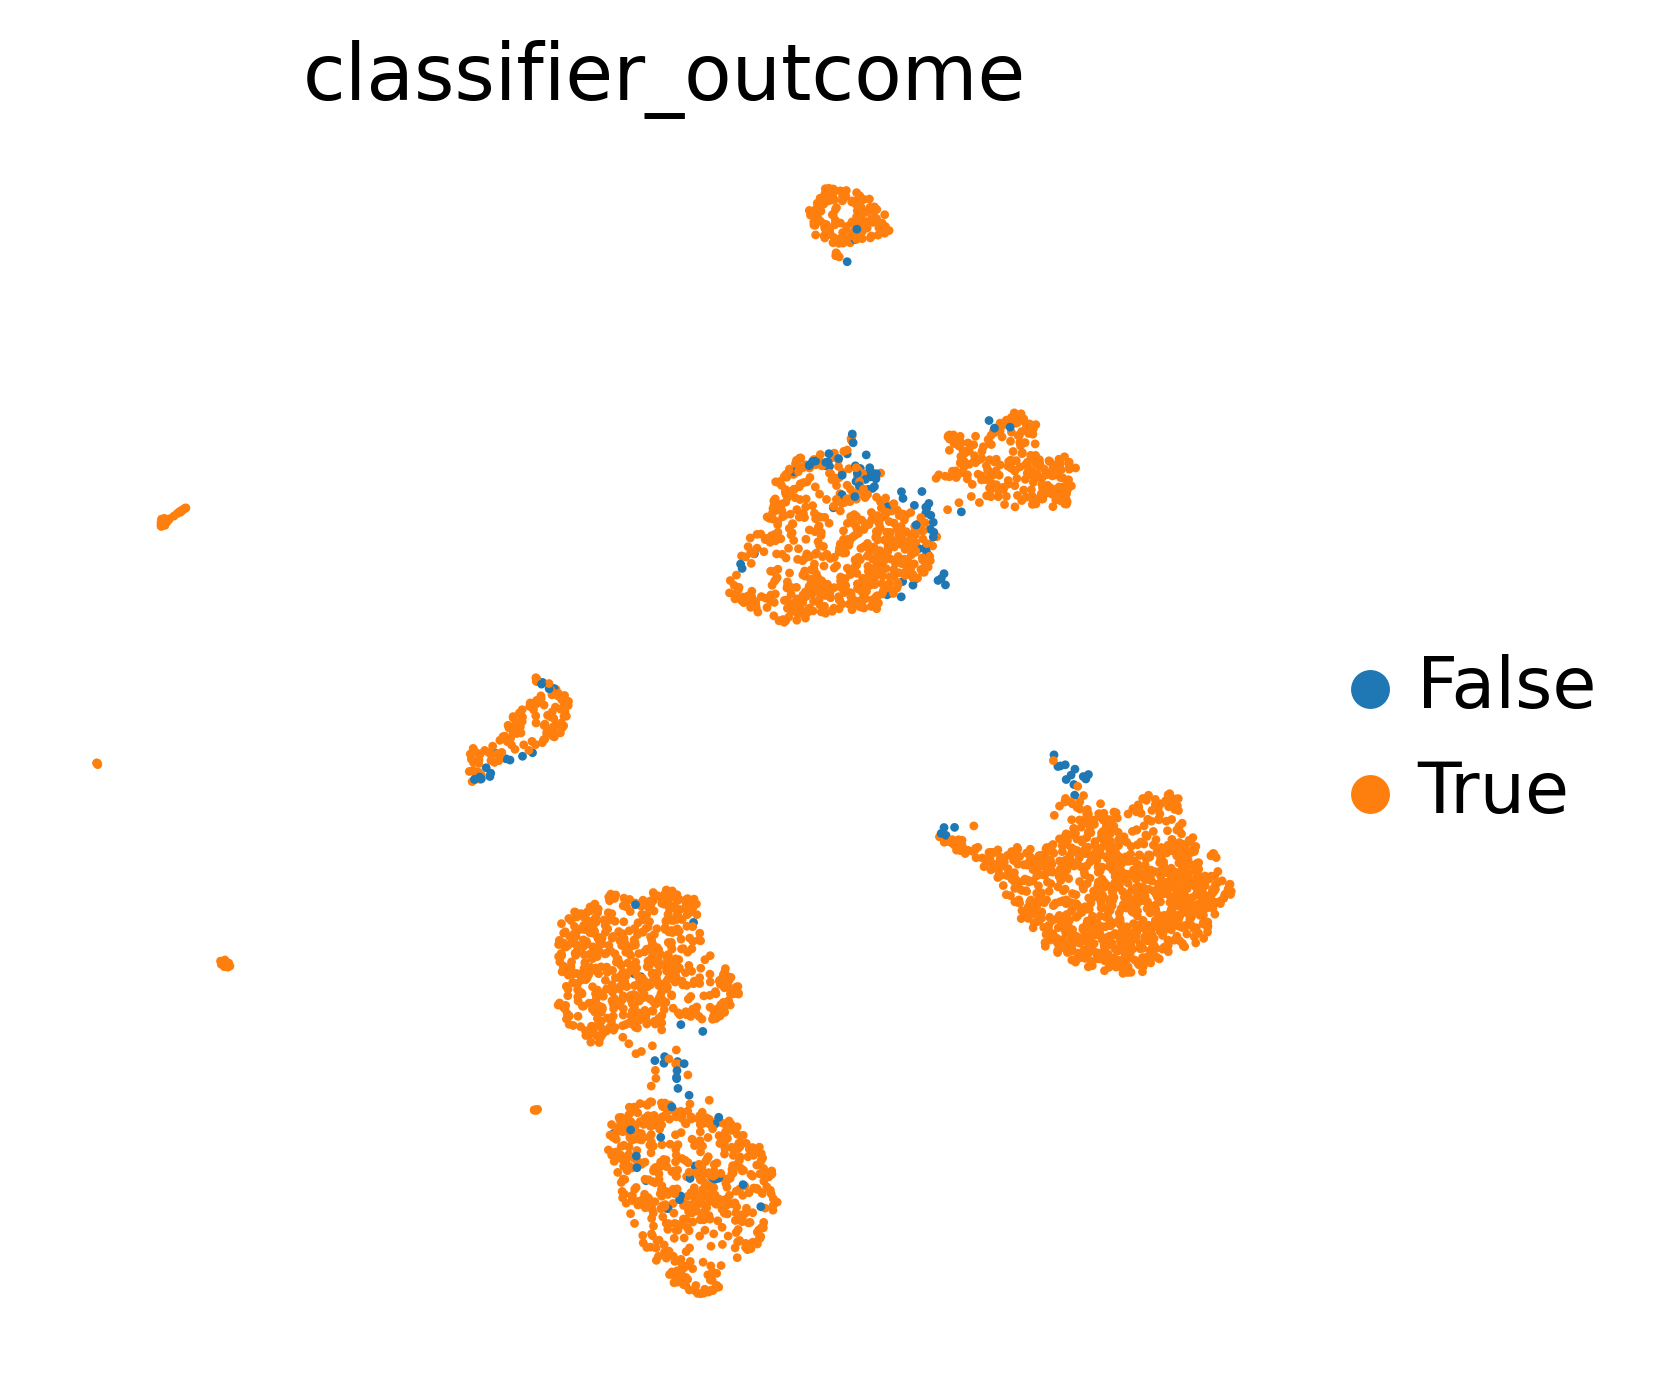

In [269]:
fig, ax = plt.subplots(1, figsize=(4, 4))
sc.pl.umap(
    adata_latent,
    wspace=1,
    size=10,
    color=['classifier_outcome'],
    frameon=False,
    show=False,
    ax=ax
)

Trying to set attribute `.uns` of view, copying.


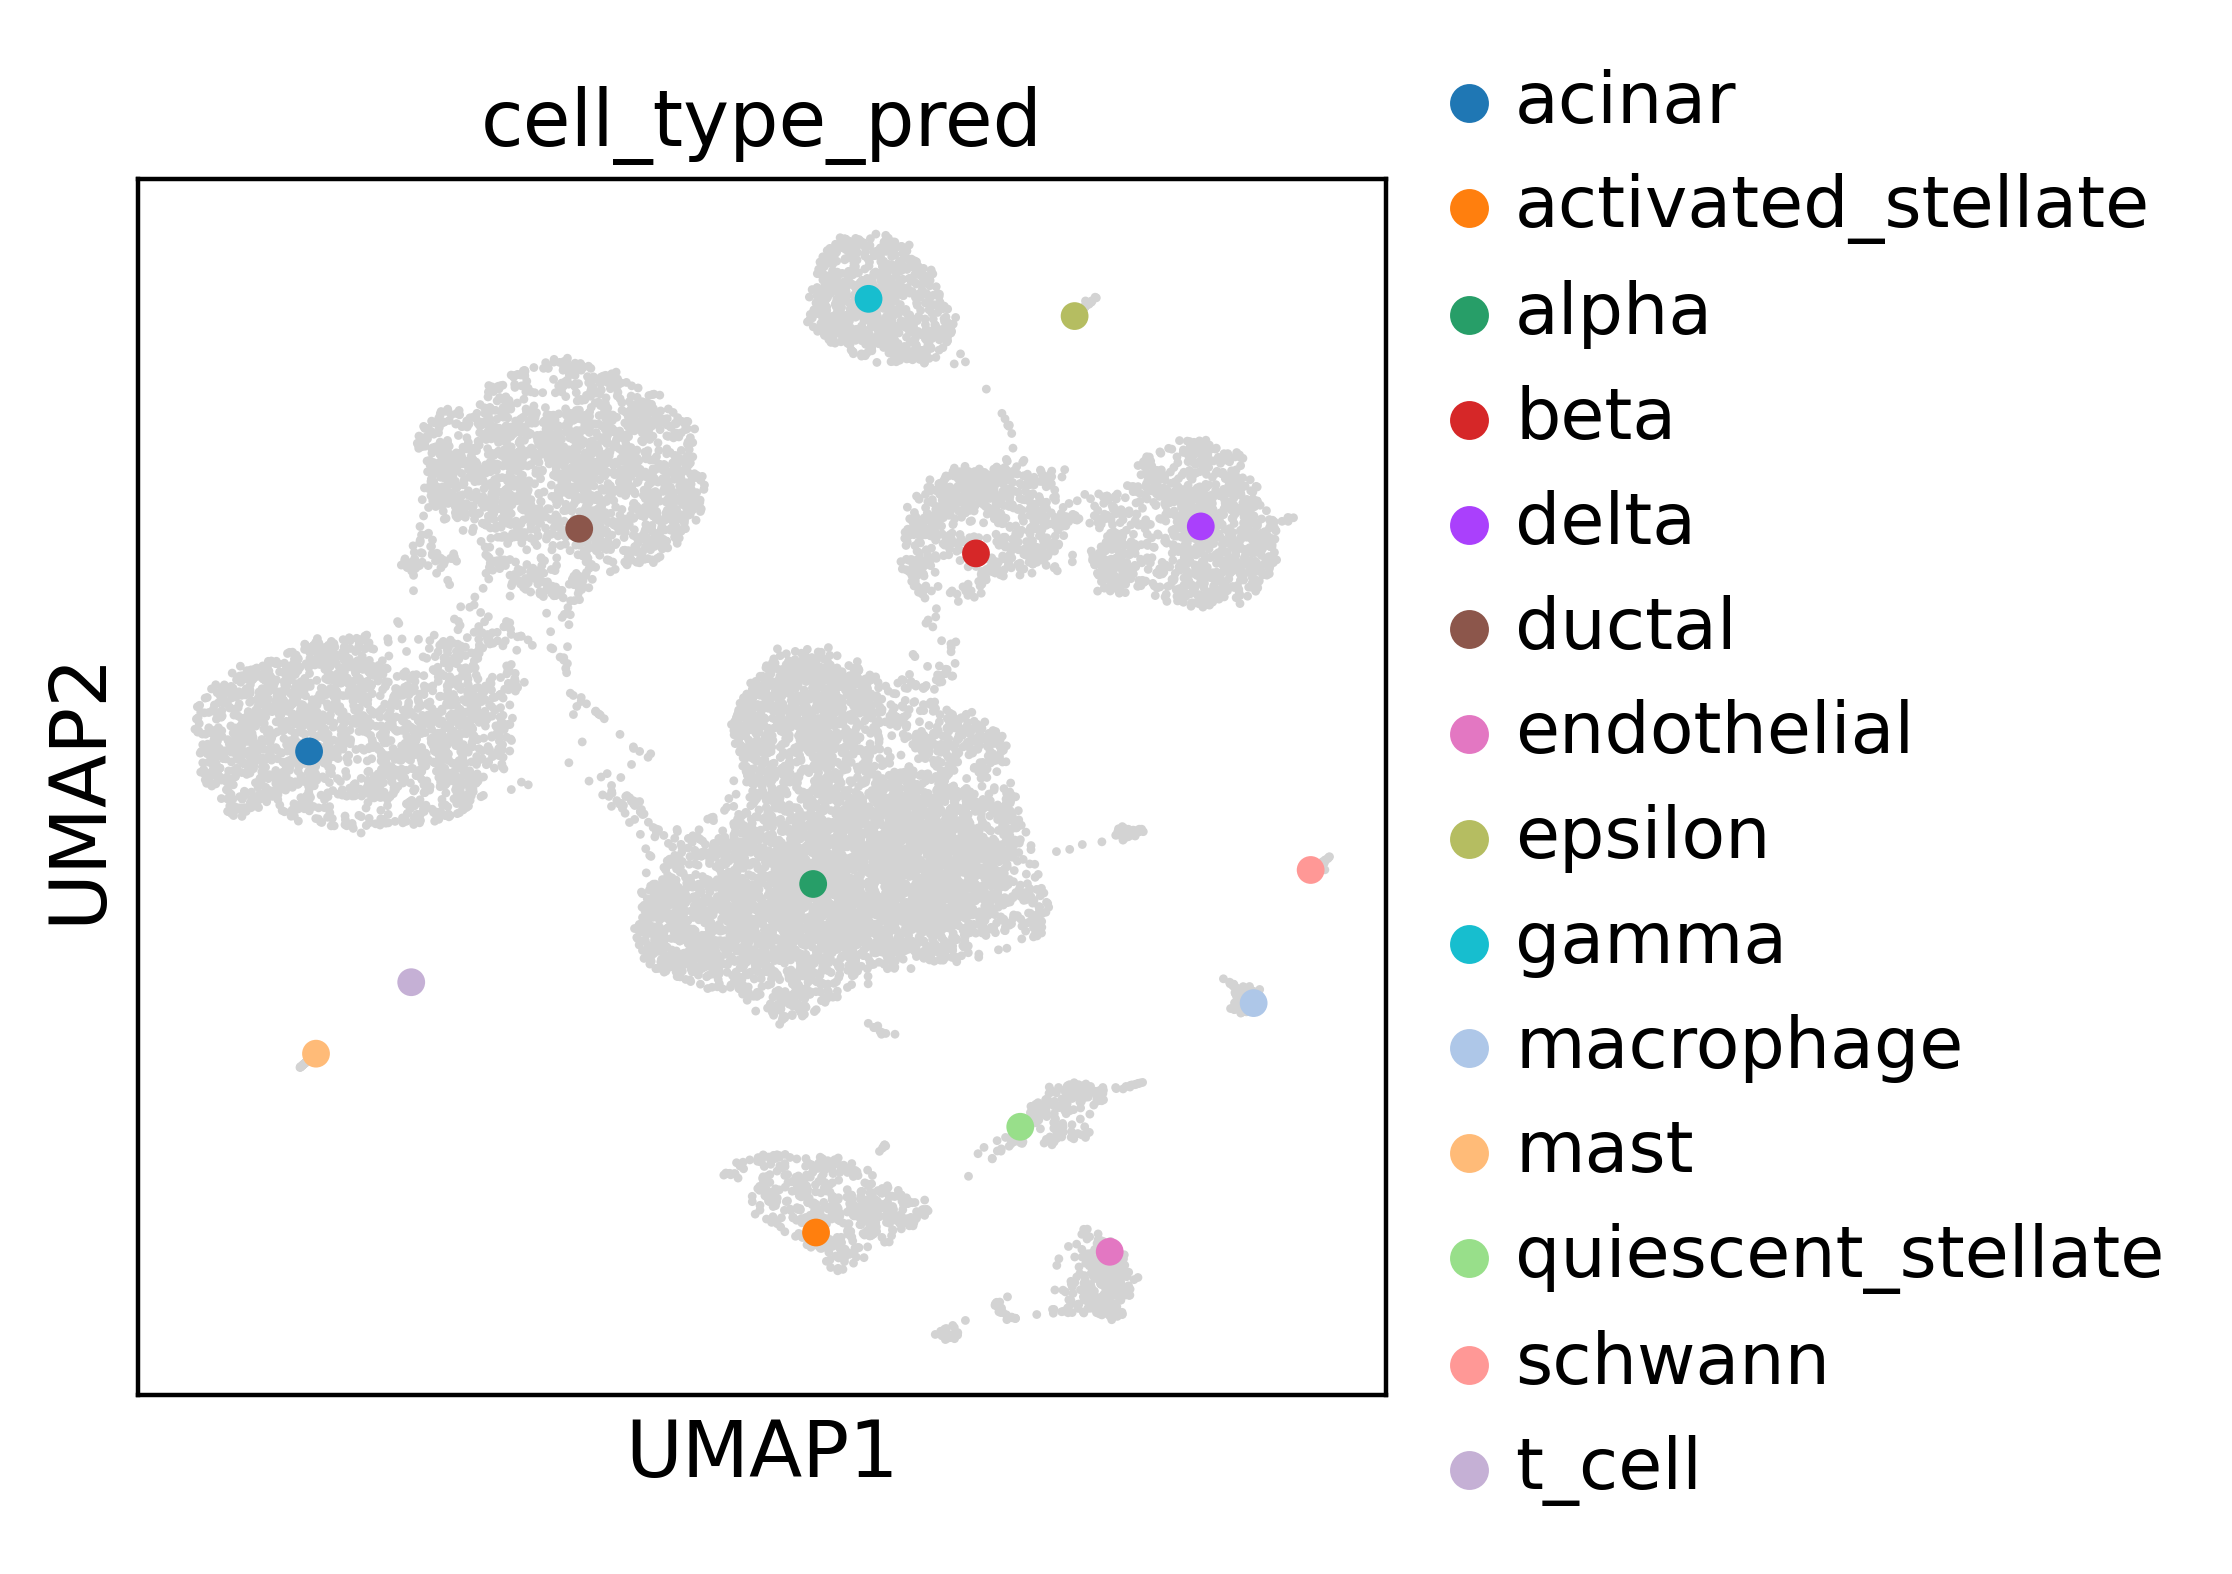

In [73]:
ax = sc.pl.umap(full_latent, size=10, show=False)
sc.pl.umap(
    full_latent[full_latent.obs[condition_key] == "Landmark-Set Labeled"],
    size=100,
    color=[cell_type_key + '_pred'],
    ax=ax
)